In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import statsmodels.api as sm
import mplcursors
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

plt.style.use('seaborn-darkgrid')

In [2]:
JobsDF = pd.read_csv('COVID_Jobs_Merged.csv', index_col = 0)

JobsDF.head()

,State,cases,deaths,All Occupations 2018,Computer Mathematical Scientists 2018,Computer Mathematical Scientists 2018 (Percent),Engineers 2018,Engineers 2018 (Percent),Life Scientists 2018,Life Scientists 2018 (Percent),Physical Scientists 2018,Physical Scientists 2018 (Percent),Science Engineer Workers 2018,Science Engineer Workers 2018 (Percent),Social Scientists 2018,Social Scientists 2018 (Percent),Technical Workers 2018,Technical Workers 2018 (Percent)
0,Alabama,387786,14345,1943760.0,34810.0,1.790859,32340.0,1.663786,3180.0,0.163600,2780.0,NaN,69821.428571,3.727577,3195.000000,0.170005,25768.461538,1.377782
1,Alaska,18316,367,315250.0,4820.0,1.528945,5060.0,1.605075,1830.0,0.580492,1670.0,NaN,14480.000000,4.593180,1090.000000,0.345757,6370.000000,2.020619
2,Arizona,426614,18857,2789520.0,92170.0,3.304153,35180.0,1.261149,4480.0,0.160601,4174.0,NaN,114216.428571,4.532470,7870.000000,0.282127,40286.923077,1.608712
3,Arkansas,161569,3301,1210120.0,21960.0,1.814696,8190.0,0.676792,2210.0,0.182627,1462.0,NaN,35500.000000,2.933593,2426.923077,0.209530,11790.000000,0.974284
4,California,2664110,102387,17007690.0,592510.0,3.483777,243550.0,1.431999,63800.0,0.375124,39360.0,NaN,989560.000000,5.818309,50350.000000,0.296043,266500.000000,1.566938


In [3]:
JobsDF.shape

(51, 18)

In [4]:
JobsDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 18 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   State                                            51 non-null     object 
 1   cases                                            51 non-null     int64  
 2   deaths                                           51 non-null     int64  
 3   All Occupations 2018                             51 non-null     float64
 4   Computer Mathematical Scientists 2018            51 non-null     float64
 5   Computer Mathematical Scientists 2018 (Percent)  51 non-null     float64
 6   Engineers 2018                                   51 non-null     float64
 7   Engineers 2018 (Percent)                         51 non-null     float64
 8   Life Scientists 2018                             51 non-null     float64
 9   Life Scientists 2018 (Percent)    

In [5]:
JobsDF.isnull().sum()

State                                               0
cases                                               0
deaths                                              0
All Occupations 2018                                0
Computer Mathematical Scientists 2018               0
Computer Mathematical Scientists 2018 (Percent)     0
Engineers 2018                                      0
Engineers 2018 (Percent)                            0
Life Scientists 2018                                0
Life Scientists 2018 (Percent)                      0
Physical Scientists 2018                            0
Physical Scientists 2018 (Percent)                 51
Science Engineer Workers 2018                       0
Science Engineer Workers 2018 (Percent)             0
Social Scientists 2018                              0
Social Scientists 2018 (Percent)                    0
Technical Workers 2018                              0
Technical Workers 2018 (Percent)                    0
dtype: int64

In [6]:
JobsDF['Physical Scientists 2018 (Percent)'] = (JobsDF['Physical Scientists 2018']/JobsDF['All Occupations 2018']) * 100

JobsDF.head()

,State,cases,deaths,All Occupations 2018,Computer Mathematical Scientists 2018,Computer Mathematical Scientists 2018 (Percent),Engineers 2018,Engineers 2018 (Percent),Life Scientists 2018,Life Scientists 2018 (Percent),Physical Scientists 2018,Physical Scientists 2018 (Percent),Science Engineer Workers 2018,Science Engineer Workers 2018 (Percent),Social Scientists 2018,Social Scientists 2018 (Percent),Technical Workers 2018,Technical Workers 2018 (Percent)
0,Alabama,387786,14345,1943760.0,34810.0,1.790859,32340.0,1.663786,3180.0,0.163600,2780.0,0.143022,69821.428571,3.727577,3195.000000,0.170005,25768.461538,1.377782
1,Alaska,18316,367,315250.0,4820.0,1.528945,5060.0,1.605075,1830.0,0.580492,1670.0,0.529738,14480.000000,4.593180,1090.000000,0.345757,6370.000000,2.020619
2,Arizona,426614,18857,2789520.0,92170.0,3.304153,35180.0,1.261149,4480.0,0.160601,4174.0,0.149631,114216.428571,4.532470,7870.000000,0.282127,40286.923077,1.608712
3,Arkansas,161569,3301,1210120.0,21960.0,1.814696,8190.0,0.676792,2210.0,0.182627,1462.0,0.120814,35500.000000,2.933593,2426.923077,0.209530,11790.000000,0.974284
4,California,2664110,102387,17007690.0,592510.0,3.483777,243550.0,1.431999,63800.0,0.375124,39360.0,0.231425,989560.000000,5.818309,50350.000000,0.296043,266500.000000,1.566938


In [7]:
JobsDF.isnull().sum()

State                                              0
cases                                              0
deaths                                             0
All Occupations 2018                               0
Computer Mathematical Scientists 2018              0
Computer Mathematical Scientists 2018 (Percent)    0
Engineers 2018                                     0
Engineers 2018 (Percent)                           0
Life Scientists 2018                               0
Life Scientists 2018 (Percent)                     0
Physical Scientists 2018                           0
Physical Scientists 2018 (Percent)                 0
Science Engineer Workers 2018                      0
Science Engineer Workers 2018 (Percent)            0
Social Scientists 2018                             0
Social Scientists 2018 (Percent)                   0
Technical Workers 2018                             0
Technical Workers 2018 (Percent)                   0
dtype: int64

In [8]:
JobsDF.count()

State                                              51
cases                                              51
deaths                                             51
All Occupations 2018                               51
Computer Mathematical Scientists 2018              51
Computer Mathematical Scientists 2018 (Percent)    51
Engineers 2018                                     51
Engineers 2018 (Percent)                           51
Life Scientists 2018                               51
Life Scientists 2018 (Percent)                     51
Physical Scientists 2018                           51
Physical Scientists 2018 (Percent)                 51
Science Engineer Workers 2018                      51
Science Engineer Workers 2018 (Percent)            51
Social Scientists 2018                             51
Social Scientists 2018 (Percent)                   51
Technical Workers 2018                             51
Technical Workers 2018 (Percent)                   51
dtype: int64

In [9]:
JobsDF.describe()

,cases,deaths,All Occupations 2018,Computer Mathematical Scientists 2018,Computer Mathematical Scientists 2018 (Percent),Engineers 2018,Engineers 2018 (Percent),Life Scientists 2018,Life Scientists 2018 (Percent),Physical Scientists 2018,Physical Scientists 2018 (Percent),Science Engineer Workers 2018,Science Engineer Workers 2018 (Percent),Social Scientists 2018,Social Scientists 2018 (Percent),Technical Workers 2018,Technical Workers 2018 (Percent)
count,5.100000e+01,5.100000e+01,5.100000e+01,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,1.056306e+06,5.861198e+04,2.837908e+06,82681.568627,2.627552,35122.724868,1.196949,7130.301839,0.268663,5943.212397,0.232169,136673.991597,4.582243,7868.013575,0.312399,37648.901099,1.357929
std,2.249183e+06,1.579360e+05,3.172568e+06,103969.632785,1.062433,42747.733421,0.373861,9733.320561,0.120491,6837.663785,0.109760,169576.763401,1.532054,9402.918697,0.337868,44530.807042,0.272459
min,1.831600e+04,2.810000e+02,2.693200e+05,2990.000000,0.977129,2720.000000,0.564162,810.000000,0.104667,720.000000,0.108322,8440.000000,2.337542,760.000000,0.120125,3700.000000,0.876134
25%,1.696980e+05,4.021000e+03,7.092550e+05,15700.000000,1.822666,7895.000000,0.942117,2070.000000,0.184265,1670.000000,0.164912,31460.000000,3.539935,1935.000000,0.197086,10775.000000,1.146223
50%,3.877860e+05,1.425100e+04,1.889870e+06,41310.000000,2.567030,27090.000000,1.136981,3180.000000,0.229651,3370.000000,0.199976,74030.000000,4.405243,3910.000000,0.251004,23580.000000,1.351106
75%,1.047118e+06,5.046050e+04,3.415255e+06,128400.000000,3.177044,45345.000000,1.423545,8710.000000,0.325384,9361.875000,0.260961,210975.000000,5.041456,9440.000000,0.314813,51040.000000,1.558345
max,1.504181e+07,1.081194e+06,1.700769e+07,592510.000000,5.798953,243550.000000,2.712242,63800.000000,0.580492,39360.000000,0.571654,989560.000000,10.392072,50350.000000,2.582927,266500.000000,2.020619


In [10]:
corr = JobsDF.corr()
corr

,cases,deaths,All Occupations 2018,Computer Mathematical Scientists 2018,Computer Mathematical Scientists 2018 (Percent),Engineers 2018,Engineers 2018 (Percent),Life Scientists 2018,Life Scientists 2018 (Percent),Physical Scientists 2018,Physical Scientists 2018 (Percent),Science Engineer Workers 2018,Science Engineer Workers 2018 (Percent),Social Scientists 2018,Social Scientists 2018 (Percent),Technical Workers 2018,Technical Workers 2018 (Percent)
cases,1.000000,0.990033,0.515661,0.465196,0.136348,0.362866,-0.062341,0.425226,-0.018975,0.462789,-0.079216,0.455138,0.079630,0.624508,0.011267,0.432131,-0.127433
deaths,0.990033,1.000000,0.424535,0.371427,0.097161,0.282872,-0.045533,0.338772,-0.020944,0.370287,-0.067507,0.365002,0.059480,0.549919,0.018696,0.338857,-0.123675
All Occupations 2018,0.515661,0.424535,1.000000,0.966959,0.245542,0.940784,0.105164,0.888921,-0.114555,0.949921,-0.189086,0.967431,0.154887,0.904331,-0.082886,0.977884,-0.070821
Computer Mathematical Scientists 2018,0.465196,0.371427,0.966959,1.000000,0.418791,0.946154,0.179892,0.932778,0.008865,0.972427,-0.085853,0.995190,0.328453,0.930739,-0.005123,0.982532,0.052089
Computer Mathematical Scientists 2018 (Percent),0.136348,0.097161,0.245542,0.418791,1.000000,0.300174,0.367980,0.330653,0.233960,0.367795,0.297296,0.390005,0.932697,0.457568,0.544943,0.301065,0.360847
Engineers 2018,0.362866,0.282872,0.940784,0.946154,0.300174,1.000000,0.363211,0.898570,-0.035239,0.947611,-0.110886,0.967955,0.271844,0.848398,-0.067228,0.969511,0.068266
Engineers 2018 (Percent),-0.062341,-0.045533,0.105164,0.179892,0.367980,0.363211,1.000000,0.182647,0.181653,0.217622,0.288354,0.227413,0.544531,0.125666,0.071486,0.192496,0.553292
Life Scientists 2018,0.425226,0.338772,0.888921,0.932778,0.330653,0.898570,0.182647,1.000000,0.206256,0.942462,-0.027409,0.943168,0.288984,0.890960,-0.010924,0.946285,0.134789
Life Scientists 2018 (Percent),-0.018975,-0.020944,-0.114555,0.008865,0.233960,-0.035239,0.181653,0.206256,1.000000,0.055228,0.482955,0.020676,0.378784,0.053912,0.189214,-0.007820,0.561903
Physical Scientists 2018,0.462789,0.370287,0.949921,0.972427,0.367795,0.947611,0.217622,0.942462,0.055228,1.000000,0.025010,0.978906,0.316263,0.905378,-0.001206,0.975110,0.079519


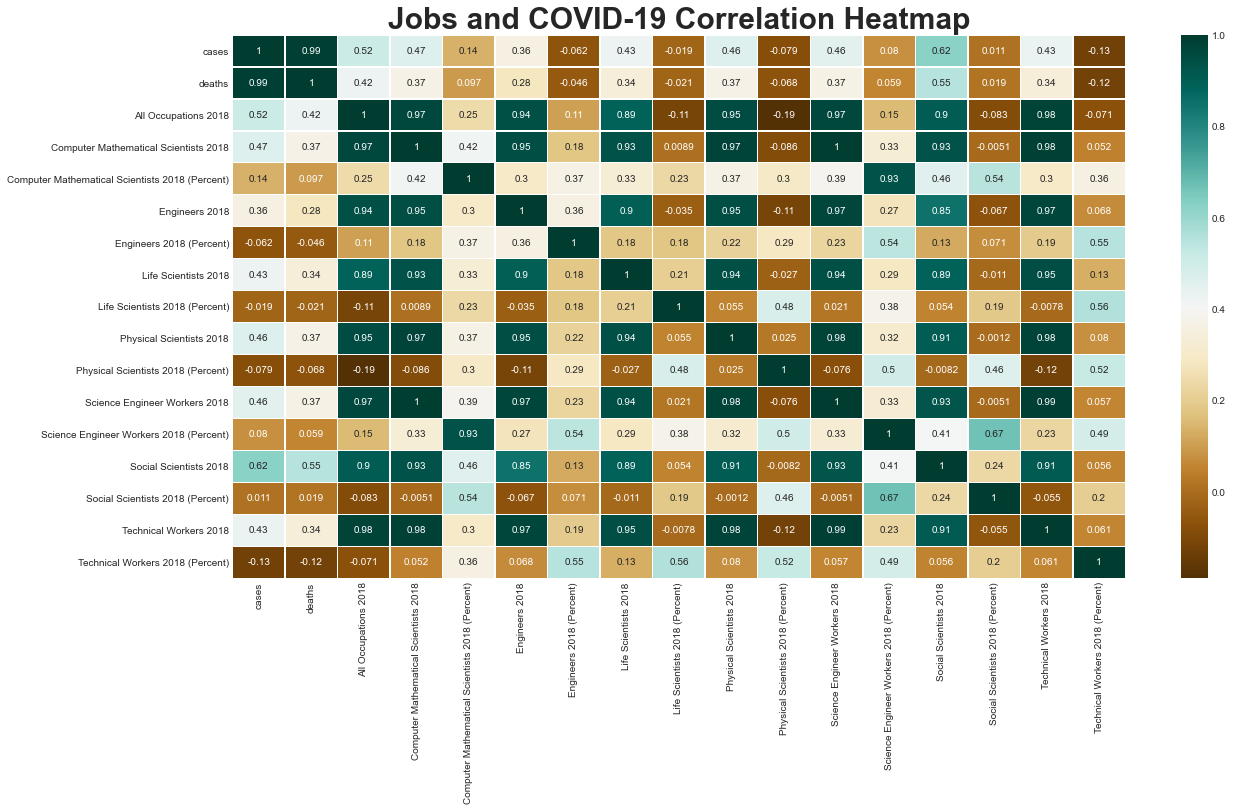

In [11]:
plt.figure(figsize = (20,10))
sns.heatmap(corr, cmap = 'BrBG', annot = True, linewidths = 0.5)
plt.title('Jobs and COVID-19 Correlation Heatmap', fontweight = 'bold', fontsize = 30);

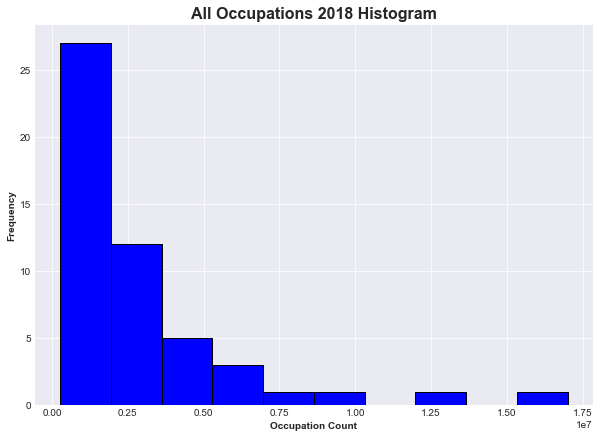

In [12]:
JobsDF['All Occupations 2018'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('All Occupations 2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

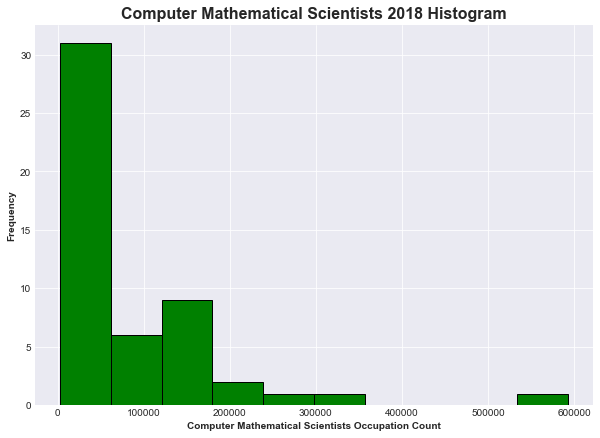

In [13]:
JobsDF['Computer Mathematical Scientists 2018'].plot(kind = 'hist', color = 'green', edgecolor = 'black', figsize = (10,7))
plt.title('Computer Mathematical Scientists 2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Computer Mathematical Scientists Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

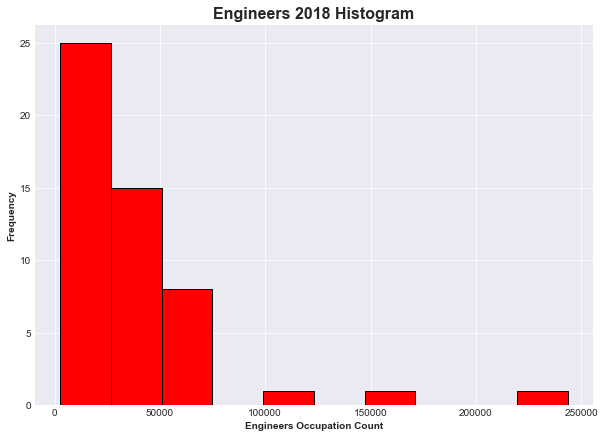

In [14]:
JobsDF['Engineers 2018'].plot(kind = 'hist', color = 'red', edgecolor = 'black', figsize = (10,7))
plt.title('Engineers 2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Engineers Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

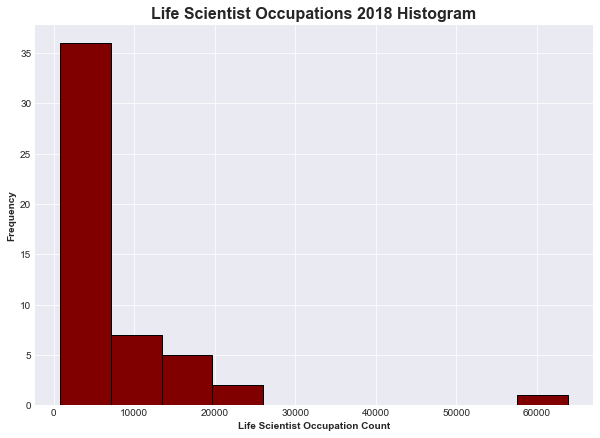

In [15]:
JobsDF['Life Scientists 2018'].plot(kind = 'hist', color = 'maroon', edgecolor = 'black', figsize = (10,7))
plt.title('Life Scientist Occupations 2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Life Scientist Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

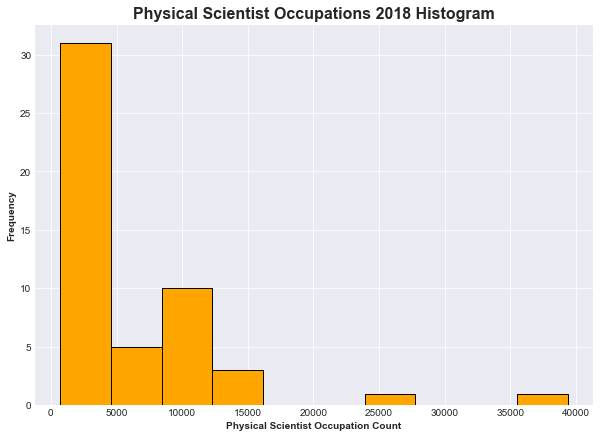

In [16]:
JobsDF['Physical Scientists 2018'].plot(kind = 'hist', color = 'orange', edgecolor = 'black', figsize = (10,7))
plt.title('Physical Scientist Occupations 2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Physical Scientist Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

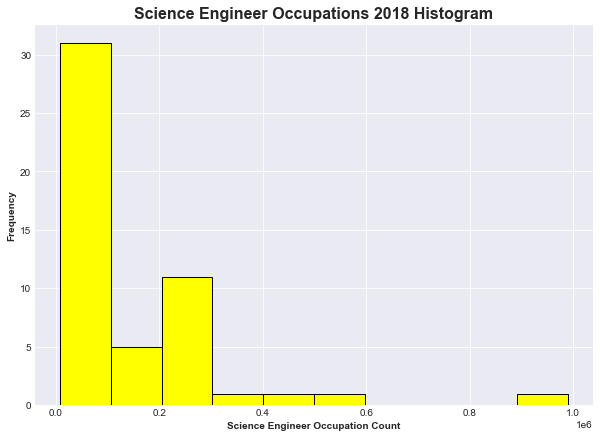

In [17]:
JobsDF['Science Engineer Workers 2018'].plot(kind = 'hist', color = 'yellow', edgecolor = 'black', figsize = (10,7))
plt.title('Science Engineer Occupations 2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Science Engineer Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

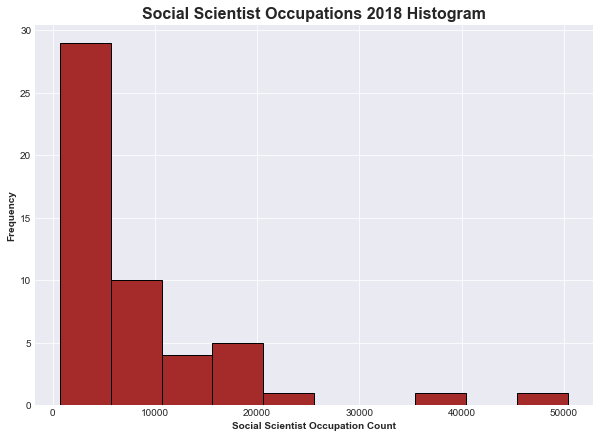

In [18]:
JobsDF['Social Scientists 2018'].plot(kind = 'hist', color = 'brown', edgecolor = 'black', figsize = (10,7))
plt.title('Social Scientist Occupations 2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Social Scientist Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

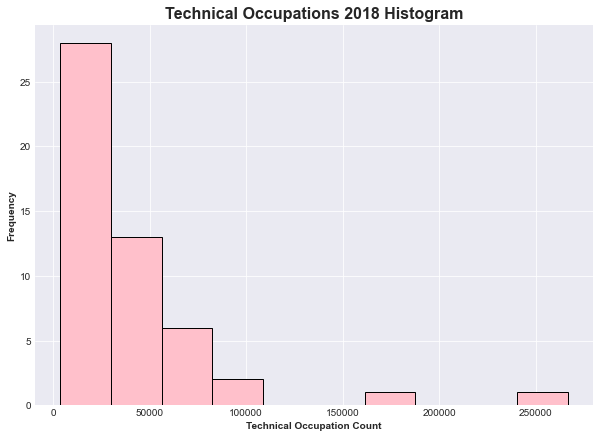

In [19]:
JobsDF['Technical Workers 2018'].plot(kind = 'hist', color = 'pink', edgecolor = 'black', figsize = (10,7))
plt.title('Technical Occupations 2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Technical Occupation Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

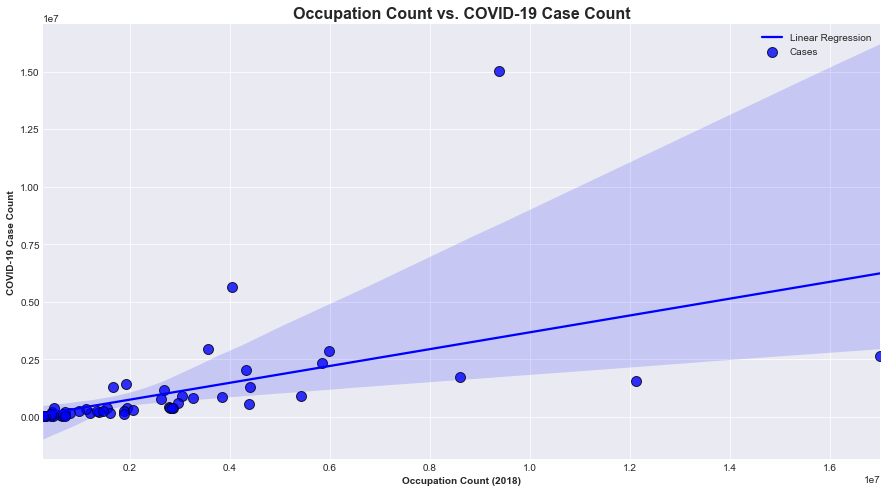

In [20]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'All Occupations 2018', y = 'cases', data = JobsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Occupation Count vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Occupation Count (2018)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [21]:
model1 = sm.OLS(JobsDF['cases'], JobsDF['All Occupations 2018']).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.401
Model:                            OLS   Adj. R-squared (uncentered):              0.389
Method:                 Least Squares   F-statistic:                              33.43
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    4.77e-07
Time:                        16:23:50   Log-Likelihood:                         -809.91
No. Observations:                  51   AIC:                                      1622.
Df Residuals:                      50   BIC:                                      1624.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
All Occupations 2018     0.3686      0.064      5.782      0.000       0.241       0.497
==============================================================================
Omnibus:                       83.073   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1421.361
Skew:                           4.363   Prob(JB):                    2.27e-309
Kurtosis:                      27.346   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

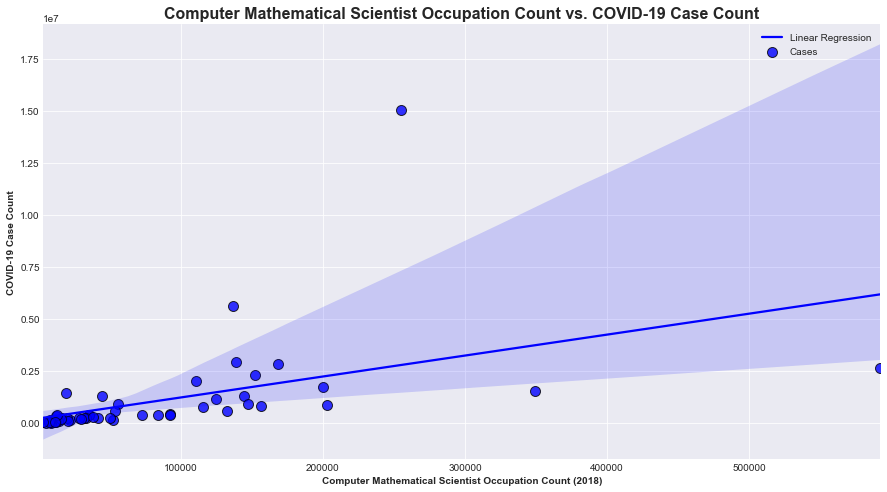

In [22]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Computer Mathematical Scientists 2018', y = 'cases', data = JobsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Computer Mathematical Scientist Occupation Count vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Computer Mathematical Scientist Occupation Count (2018)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [23]:
model2 = sm.OLS(JobsDF['cases'], JobsDF['Computer Mathematical Scientists 2018']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.355
Model:                            OLS   Adj. R-squared (uncentered):              0.342
Method:                 Least Squares   F-statistic:                              27.55
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    3.13e-06
Time:                        16:23:51   Log-Likelihood:                         -811.77
No. Observations:                  51   AIC:                                      1626.
Df Residuals:                      50   BIC:                                      1627.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Computer Mathematical Scientists 2018    11.1270      2.120      5.249      0.000       6.869      15.385
==============================================================================
Omnibus:                       84.102   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1510.149
Skew:                           4.422   Prob(JB):                         0.00
Kurtosis:                      28.148   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

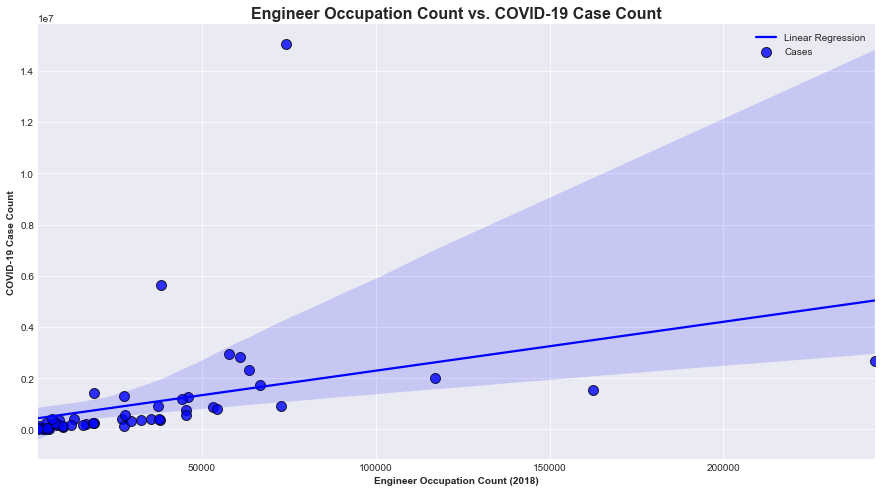

In [24]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Engineers 2018', y = 'cases', data = JobsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Engineer Occupation Count vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Engineer Occupation Count (2018)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [25]:
model3 = sm.OLS(JobsDF['cases'], JobsDF['Engineers 2018']).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.277
Model:                            OLS   Adj. R-squared (uncentered):              0.262
Method:                 Least Squares   F-statistic:                              19.12
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    6.22e-05
Time:                        16:23:51   Log-Likelihood:                         -814.71
No. Observations:                  51   AIC:                                      1631.
Df Residuals:                      50   BIC:                                      1633.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Engineers 2018    23.5708      5.390      4.373      0.000      12.744      34.397
==============================================================================
Omnibus:                       90.397   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1863.873
Skew:                           4.921   Prob(JB):                         0.00
Kurtosis:                      30.933   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

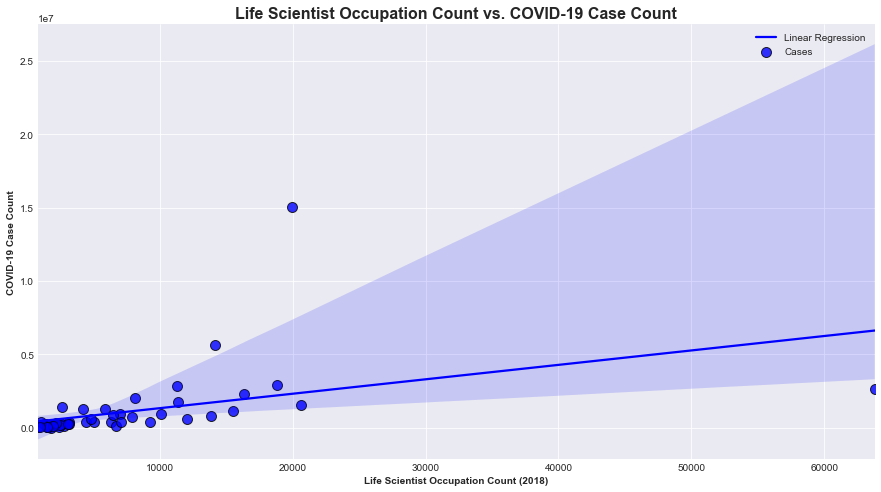

In [26]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Life Scientists 2018', y = 'cases', data = JobsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Life Scientist Occupation Count vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Life Scientist Occupation Count (2018)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [27]:
model4 = sm.OLS(JobsDF['cases'], JobsDF['Life Scientists 2018']).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.318
Model:                            OLS   Adj. R-squared (uncentered):              0.304
Method:                 Least Squares   F-statistic:                              23.29
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    1.35e-05
Time:                        16:23:51   Log-Likelihood:                         -813.21
No. Observations:                  51   AIC:                                      1628.
Df Residuals:                      50   BIC:                                      1630.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Life Scientists 2018   115.9071     24.016      4.826      0.000      67.670     164.144
==============================================================================
Omnibus:                       85.181   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1666.466
Skew:                           4.457   Prob(JB):                         0.00
Kurtosis:                      29.547   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

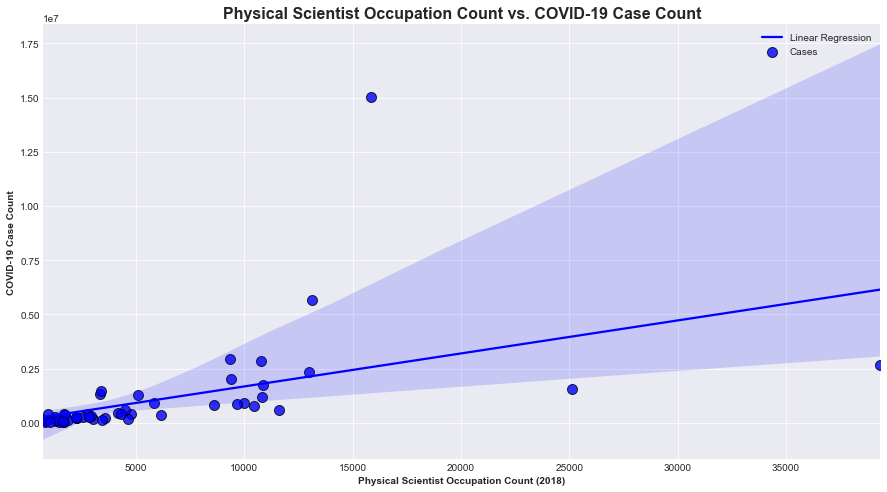

In [28]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Physical Scientists 2018', y = 'cases', data = JobsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Physical Scientist Occupation Count vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Physical Scientist Occupation Count (2018)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [29]:
model5 = sm.OLS(JobsDF['cases'], JobsDF['Physical Scientists 2018']).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.356
Model:                            OLS   Adj. R-squared (uncentered):              0.343
Method:                 Least Squares   F-statistic:                              27.68
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    3.00e-06
Time:                        16:23:52   Log-Likelihood:                         -811.73
No. Observations:                  51   AIC:                                      1625.
Df Residuals:                      50   BIC:                                      1627.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Physical Scientists 2018   163.3294     31.043      5.261      0.000     100.979     225.680
==============================================================================
Omnibus:                       88.256   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1813.069
Skew:                           4.713   Prob(JB):                         0.00
Kurtosis:                      30.647   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

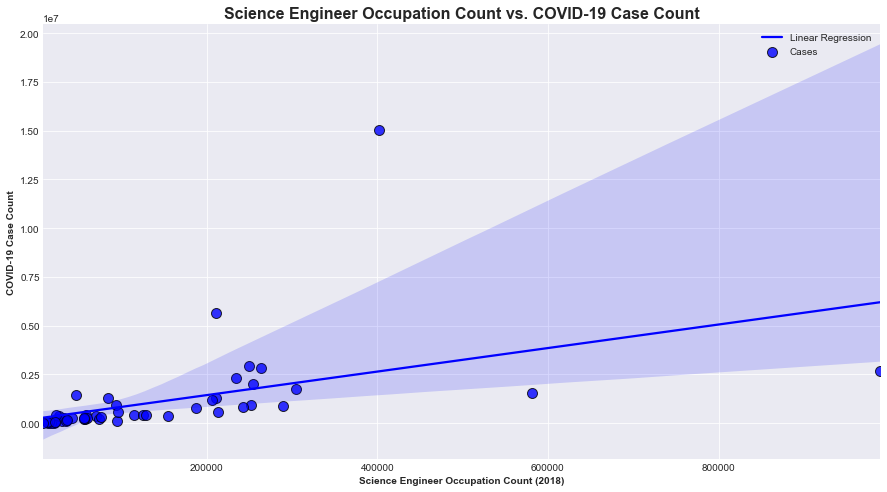

In [30]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Science Engineer Workers 2018', y = 'cases', data = JobsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Science Engineer Occupation Count vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Science Engineer Occupation Count (2018)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [31]:
model6 = sm.OLS(JobsDF['cases'], JobsDF['Science Engineer Workers 2018']).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.347
Model:                            OLS   Adj. R-squared (uncentered):              0.334
Method:                 Least Squares   F-statistic:                              26.62
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    4.27e-06
Time:                        16:23:52   Log-Likelihood:                         -812.08
No. Observations:                  51   AIC:                                      1626.
Df Residuals:                      50   BIC:                                      1628.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Science Engineer Workers 2018     6.7110      1.301      5.160      0.000       4.099       9.323
==============================================================================
Omnibus:                       85.237   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1581.912
Skew:                           4.503   Prob(JB):                         0.00
Kurtosis:                      28.755   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

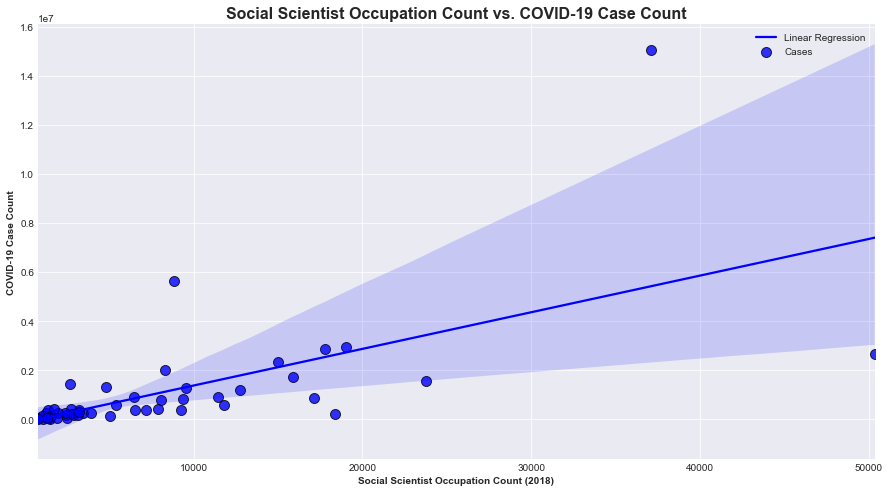

In [32]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Social Scientists 2018', y = 'cases', data = JobsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Social Scientist Occupation Count vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Social Scientist Occupation Count (2018)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [33]:
model7 = sm.OLS(JobsDF['cases'], JobsDF['Social Scientists 2018']).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.501
Model:                            OLS   Adj. R-squared (uncentered):              0.491
Method:                 Least Squares   F-statistic:                              50.14
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    4.49e-09
Time:                        16:23:52   Log-Likelihood:                         -805.26
No. Observations:                  51   AIC:                                      1613.
Df Residuals:                      50   BIC:                                      1614.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Social Scientists 2018   143.0793     20.207      7.081      0.000     102.492     183.666
==============================================================================
Omnibus:                       69.246   Durbin-Watson:                   2.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              830.498
Skew:                           3.418   Prob(JB):                    4.57e-181
Kurtosis:                      21.550   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

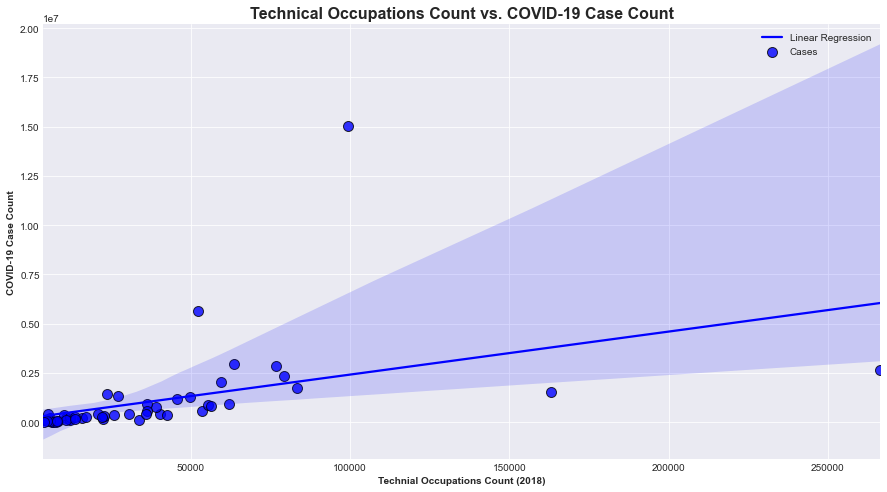

In [34]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Technical Workers 2018', y = 'cases', data = JobsDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Technical Occupations Count vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Technial Occupations Count (2018)', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [35]:
model8 = sm.OLS(JobsDF['cases'], JobsDF['Technical Workers 2018']).fit()
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.331
Model:                            OLS   Adj. R-squared (uncentered):              0.317
Method:                 Least Squares   F-statistic:                              24.72
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    8.18e-06
Time:                        16:23:53   Log-Likelihood:                         -812.72
No. Observations:                  51   AIC:                                      1627.
Df Residuals:                      50   BIC:                                      1629.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Technical Workers 2018    24.4534      4.918      4.972      0.000      14.575      34.332
==============================================================================
Omnibus:                       87.288   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1702.986
Skew:                           4.660   Prob(JB):                         0.00
Kurtosis:                      29.731   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
model9 = sm.OLS(JobsDF['cases'], JobsDF[['All Occupations 2018', 'Computer Mathematical Scientists 2018', 
                                        'Engineers 2018', 'Life Scientists 2018', 'Physical Scientists 2018',
                                        'Science Engineer Workers 2018', 'Social Scientists 2018',
                                        'Technical Workers 2018']]).fit()
model9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.713
Model:                            OLS   Adj. R-squared (uncentered):              0.660
Method:                 Least Squares   F-statistic:                              13.37
Date:                Tue, 09 Jun 2020   Prob (F-statistic):                    1.80e-09
Time:                        16:23:53   Log-Likelihood:                         -791.11
No. Observations:                  51   AIC:                                      1598.
Df Residuals:                      43   BIC:                                      1614.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
All Occupations 2018                      1.5722      0.407      3.859      0.000       0.751       2.394
Computer Mathematical Scientists 2018   -14.1732     35.028     -0.405      0.688     -84.813      56.467
Engineers 2018                           -2.7312     40.441     -0.068      0.946     -84.289      78.827
Life Scientists 2018                    132.3506    102.838      1.287      0.205     -75.041     339.742
Physical Scientists 2018                142.7844    149.232      0.957      0.344    -158.171     443.739
Science Engineer Workers 2018             1.9134     30.585      0.063      0.950     -59.767      63.594
Social Scientists 2018                  247.8153     70.009      3.540      0.001     106.628     389.003
Technical Workers 2018                 -159.0626     56.880     -2.796      0.008    -273.771     -44.354
==============================================================================
Omnibus:                       19.491   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.028
Skew:                           0.793   Prob(JB):                     1.25e-14
Kurtosis:                       8.255   Cond. No.                     3.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

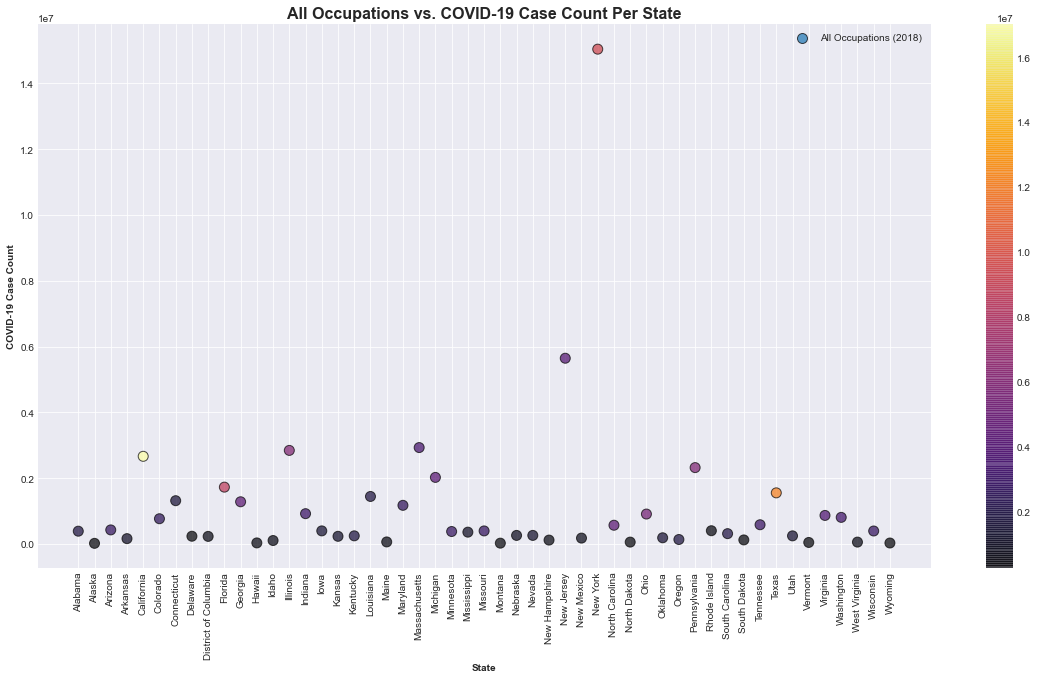

In [37]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = JobsDF['State'] 
y = JobsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = JobsDF['All Occupations 2018'], cmap = 'inferno')
plt.title('All Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['All Occupations (2018)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

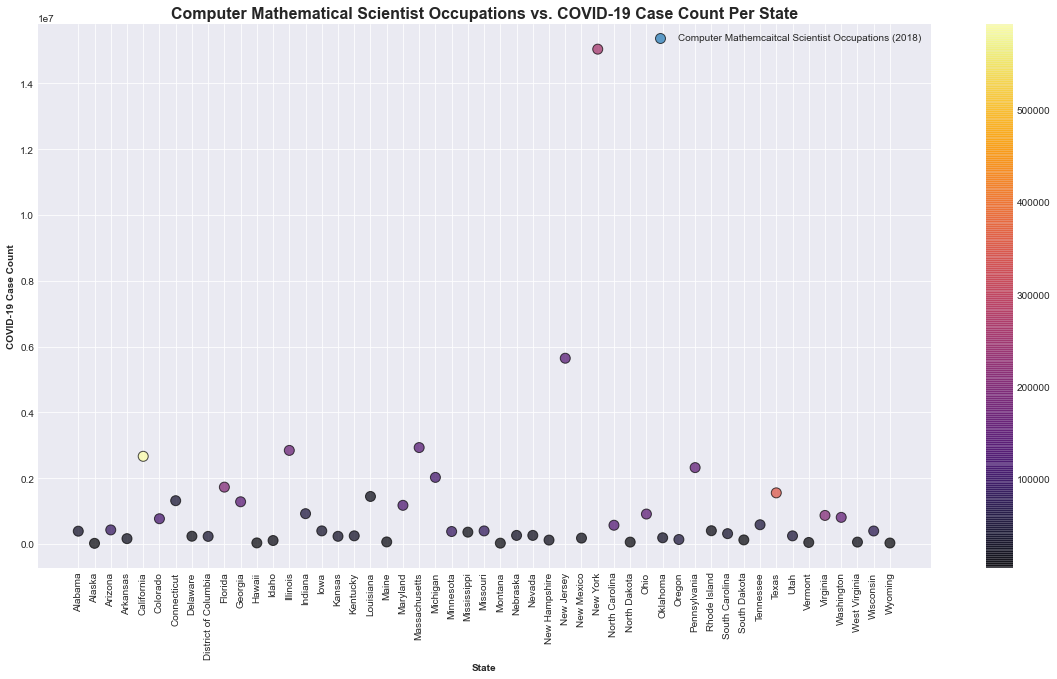

In [38]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = JobsDF['State'] 
y = JobsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = JobsDF['Computer Mathematical Scientists 2018'], cmap = 'inferno')
plt.title('Computer Mathematical Scientist Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Computer Mathemcaitcal Scientist Occupations (2018)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

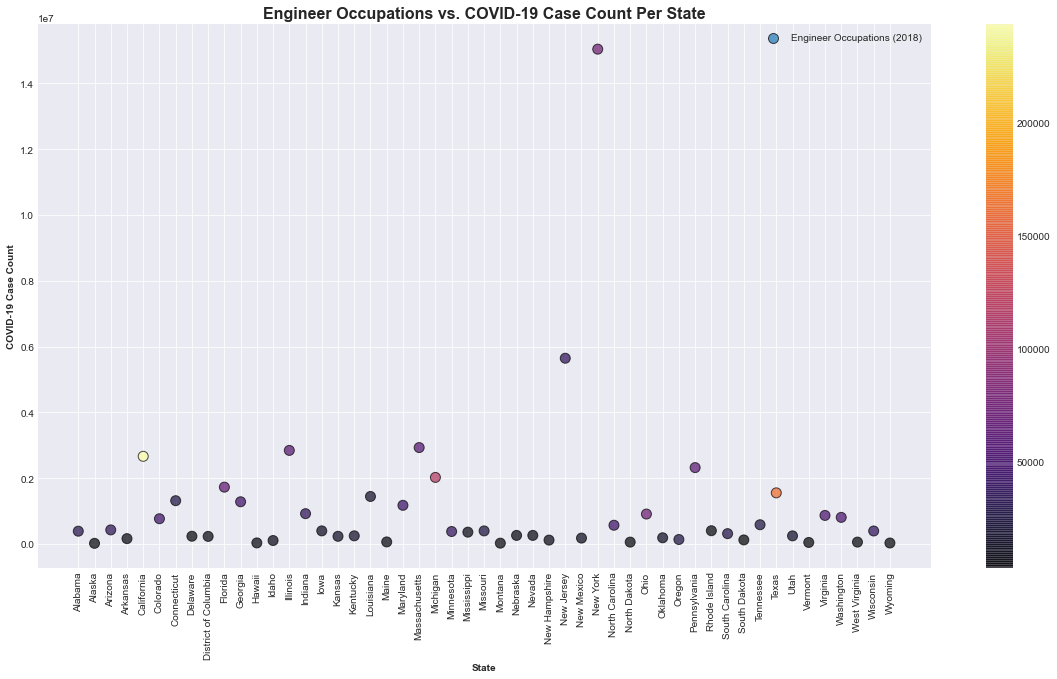

In [39]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = JobsDF['State'] 
y = JobsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = JobsDF['Engineers 2018'], cmap = 'inferno')
plt.title('Engineer Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Engineer Occupations (2018)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

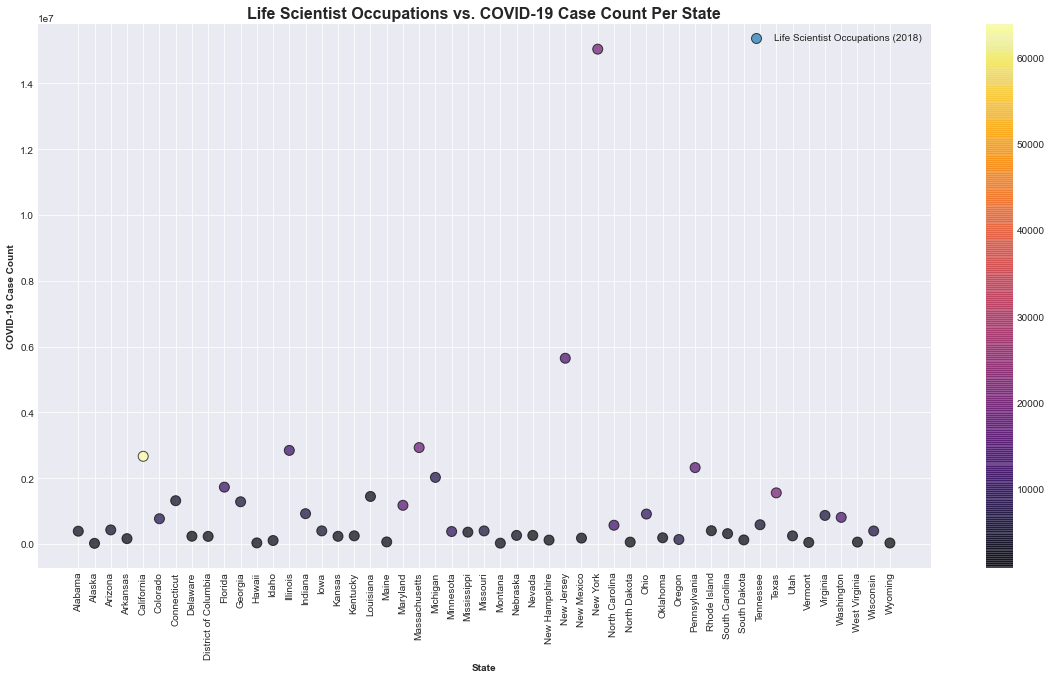

In [40]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = JobsDF['State'] 
y = JobsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = JobsDF['Life Scientists 2018'], cmap = 'inferno')
plt.title('Life Scientist Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Life Scientist Occupations (2018)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

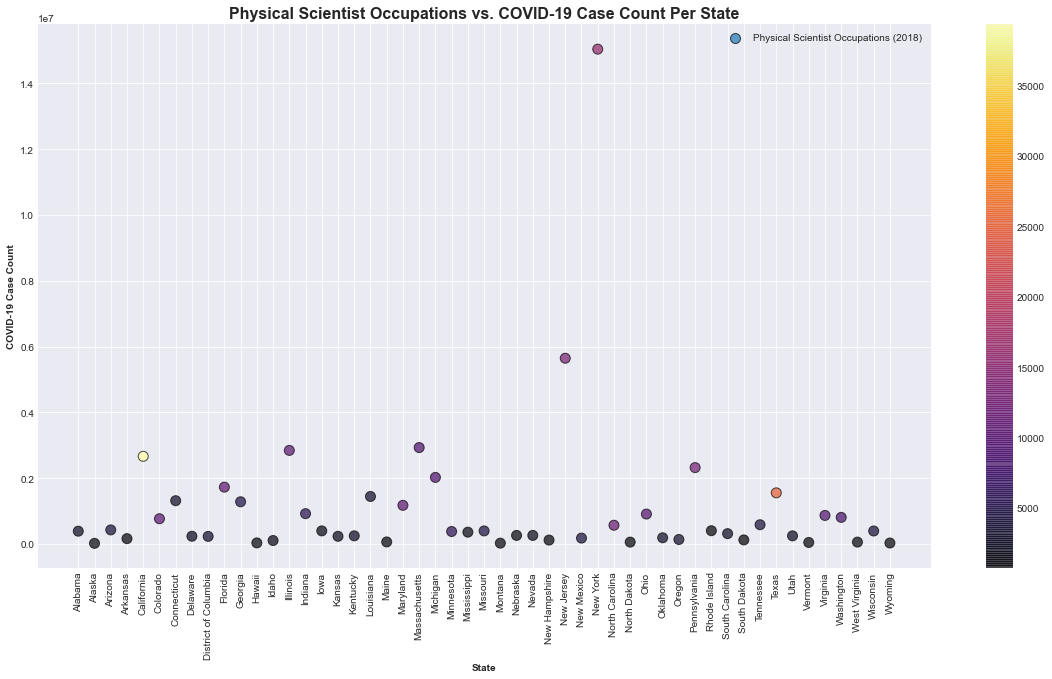

In [41]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = JobsDF['State'] 
y = JobsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = JobsDF['Physical Scientists 2018'], cmap = 'inferno')
plt.title('Physical Scientist Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Physical Scientist Occupations (2018)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

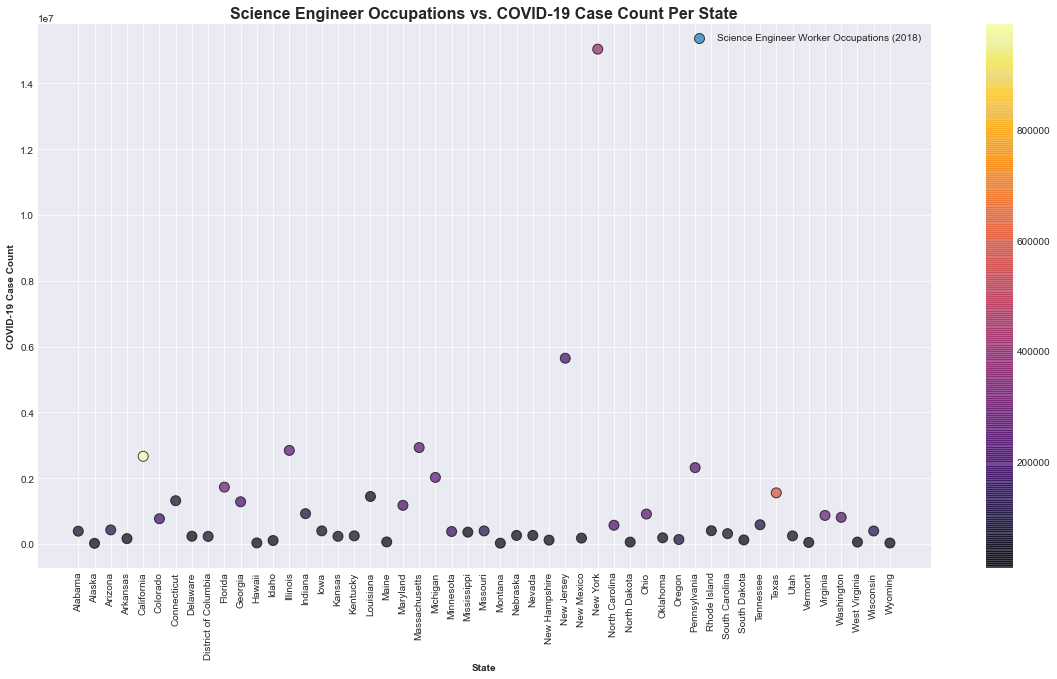

In [42]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = JobsDF['State'] 
y = JobsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = JobsDF['Science Engineer Workers 2018'], cmap = 'inferno')
plt.title('Science Engineer Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Science Engineer Worker Occupations (2018)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

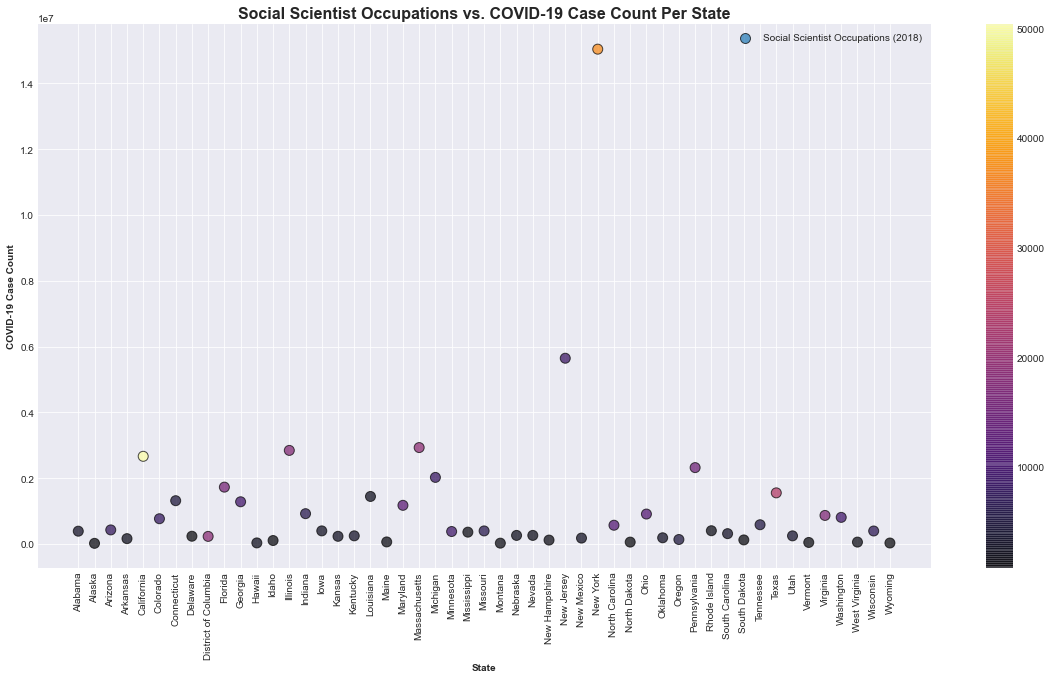

In [43]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = JobsDF['State'] 
y = JobsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = JobsDF['Social Scientists 2018'], cmap = 'inferno')
plt.title('Social Scientist Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Social Scientist Occupations (2018)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

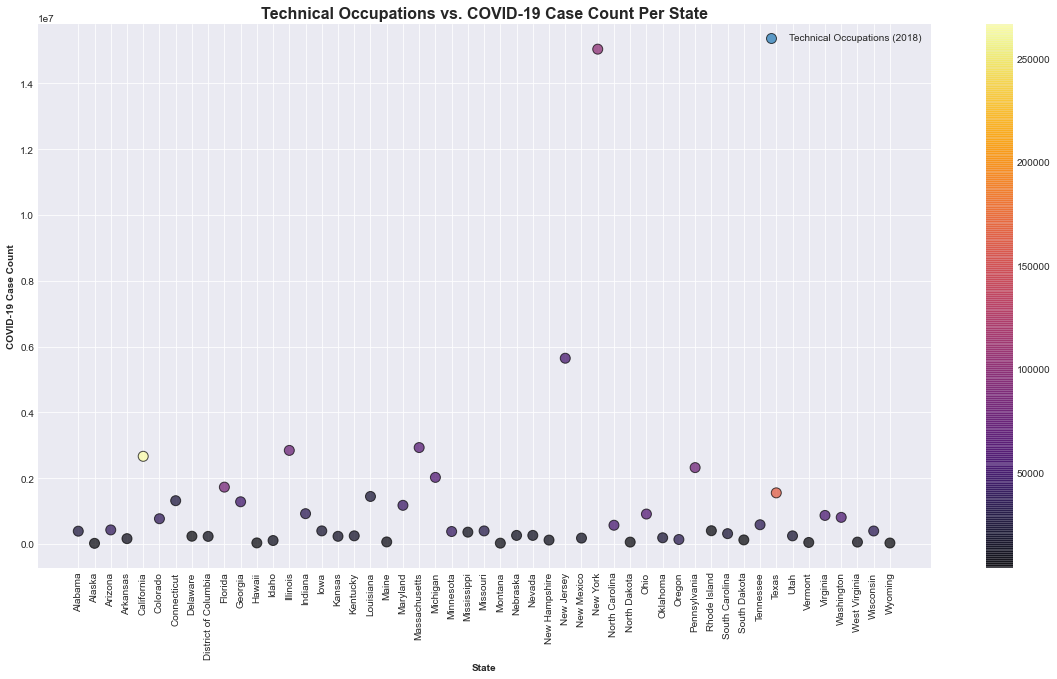

In [44]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = JobsDF['State'] 
y = JobsDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = JobsDF['Technical Workers 2018'], cmap = 'inferno')
plt.title('Technical Occupations vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Technical Occupations (2018)'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

In [45]:
test_len = int(0.25 * len(JobsDF))
train_len = len(JobsDF) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = JobsDF[:train_len]
test = JobsDF[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 18)
Test Set Shape: (12, 18)


In [46]:
features_list = ['All Occupations 2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions = SVRLinModel.predict(X_train_scaled)
test_predictions = SVRLinModel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 451532.9866763703
MSE Value: 387746366579.2209
RMS Value: 622692.8348545701
R2 Score: -1.1088693031724288


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


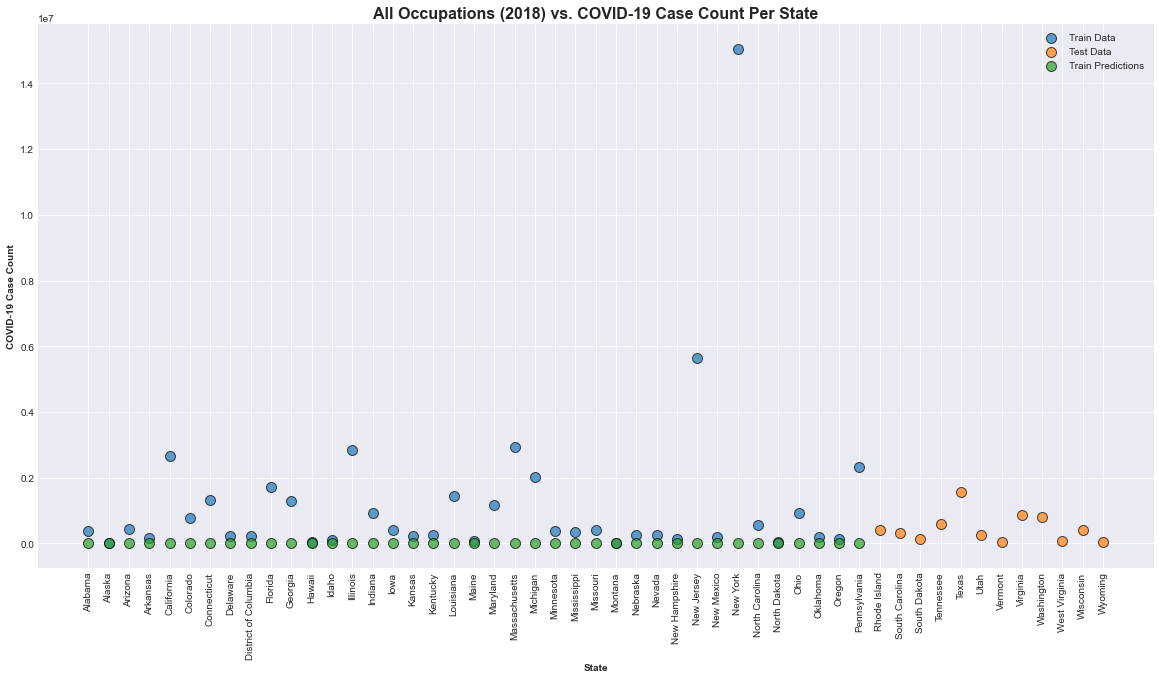

In [47]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Occupations (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

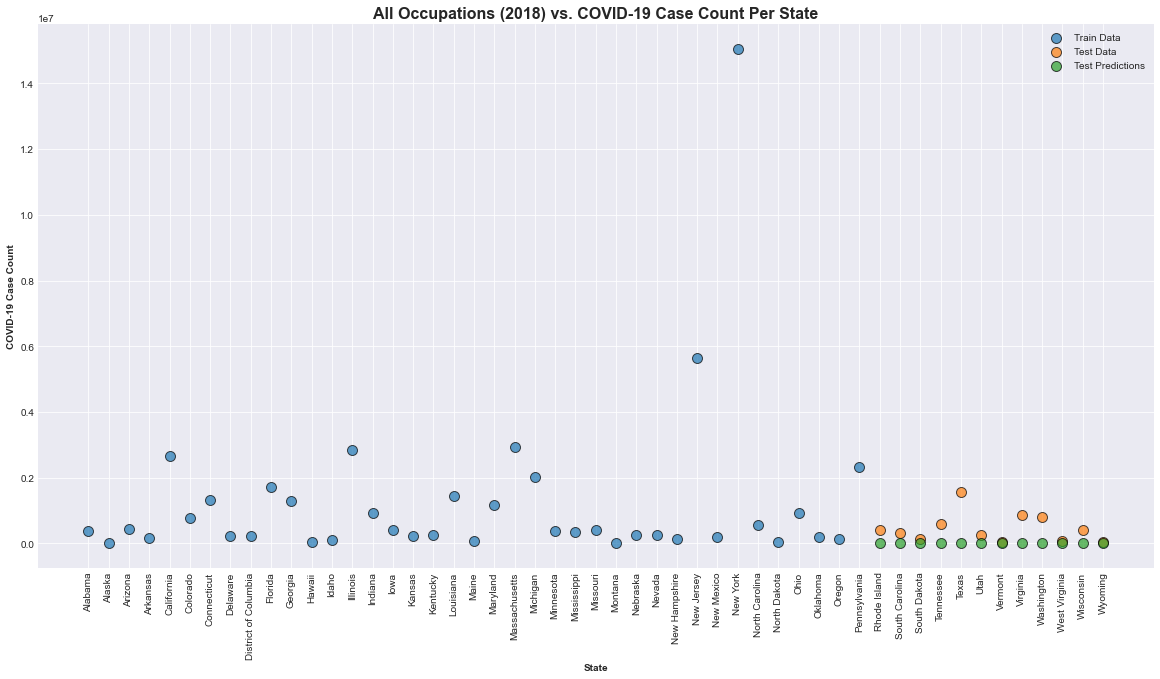

In [48]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('All Occupations (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [49]:
features_list = ['Computer Mathematical Scientists 2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions = SVRLinModel.predict(X_train_scaled)
test_predictions = SVRLinModel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 451533.22940533777
MSE Value: 387746827744.88116
RMS Value: 622693.2051539355
R2 Score: -1.1088718113535196


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


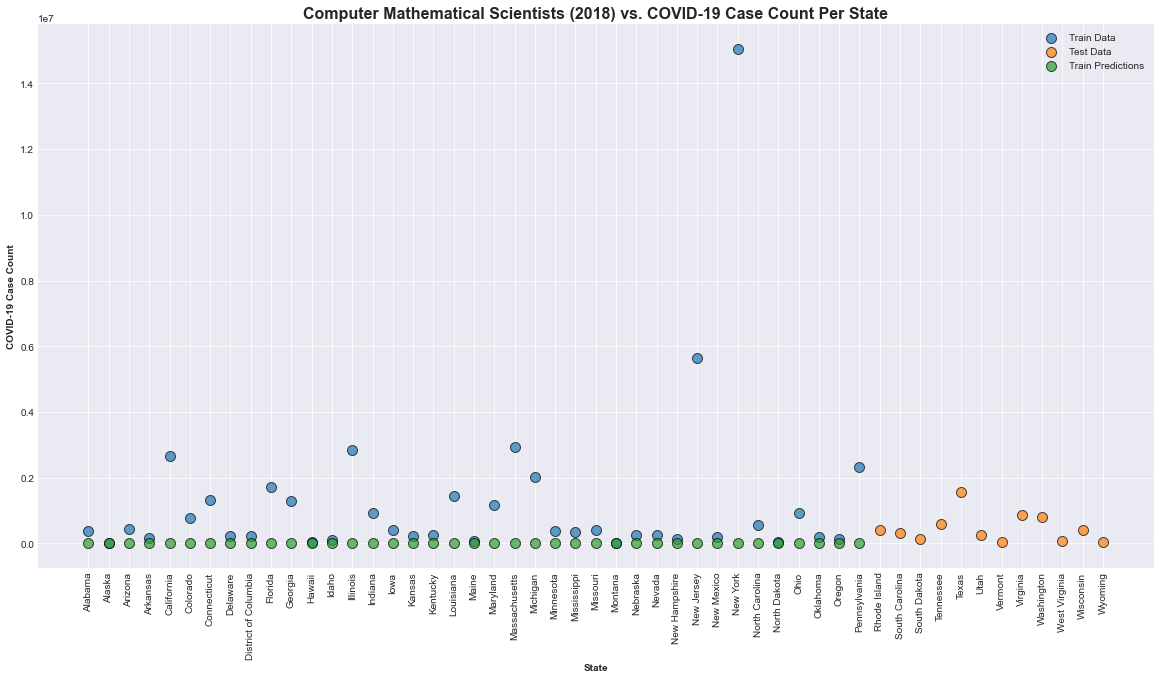

In [50]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Computer Mathematical Scientists (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

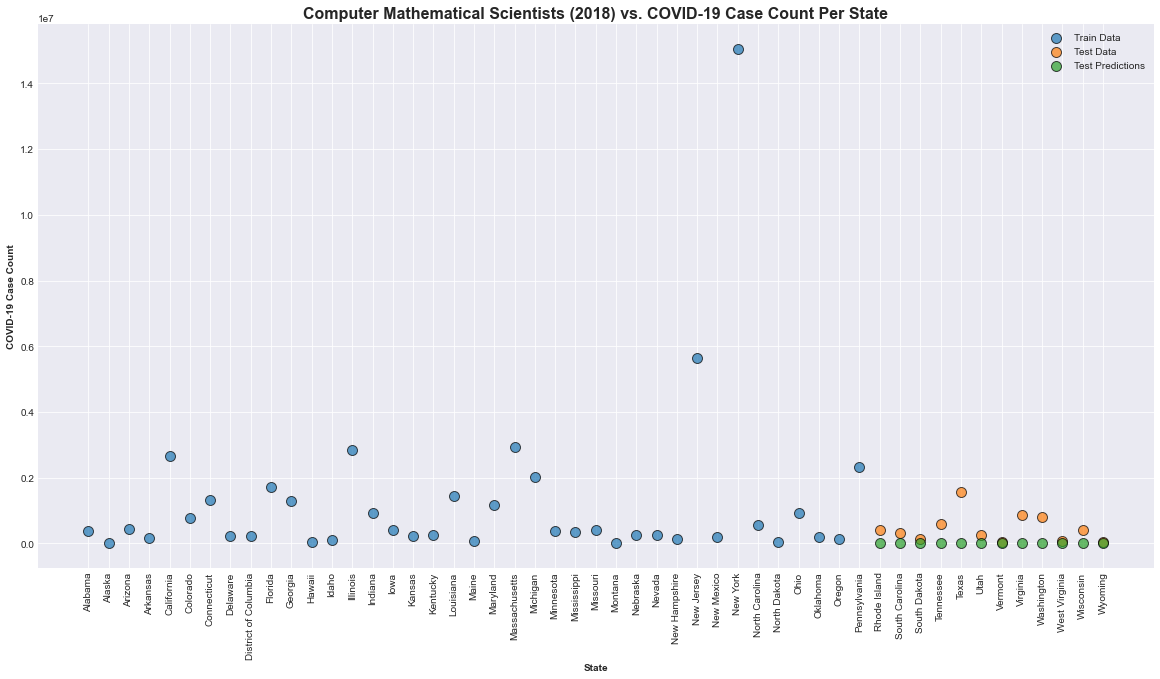

In [51]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Computer Mathematical Scientists (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [52]:
features_list = ['Engineers 2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions = SVRLinModel.predict(X_train_scaled)
test_predictions = SVRLinModel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 451533.24327863724
MSE Value: 387746845698.9283
RMS Value: 622693.2195703823
R2 Score: -1.10887190900173


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


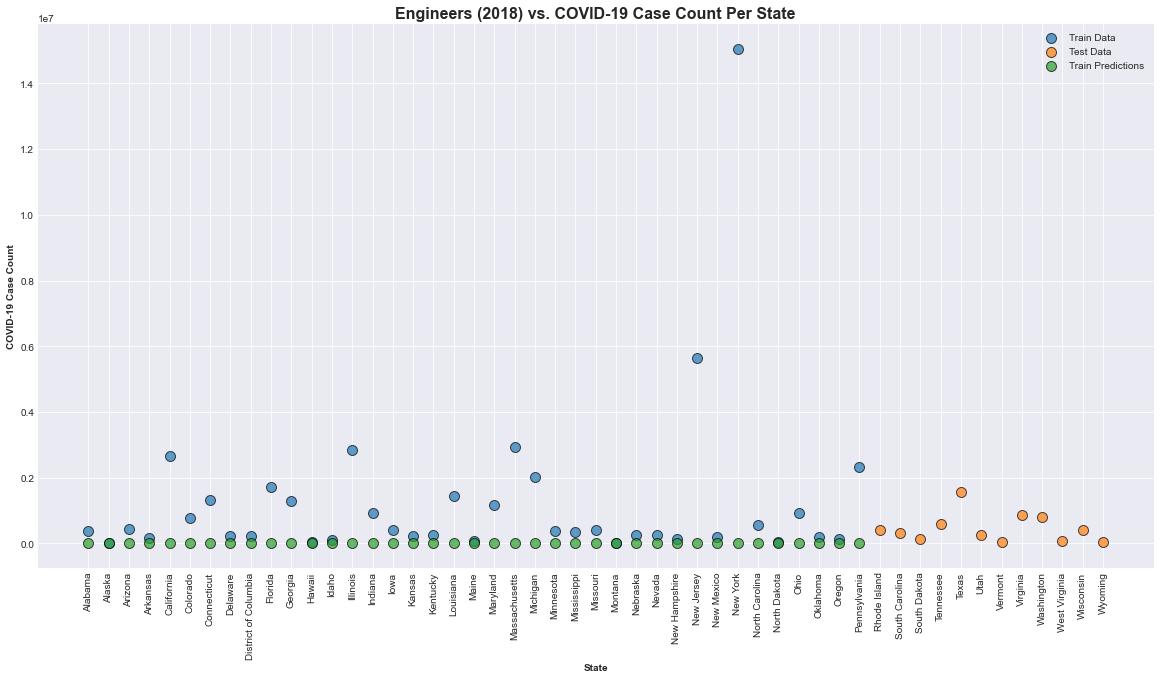

In [53]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Engineers (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

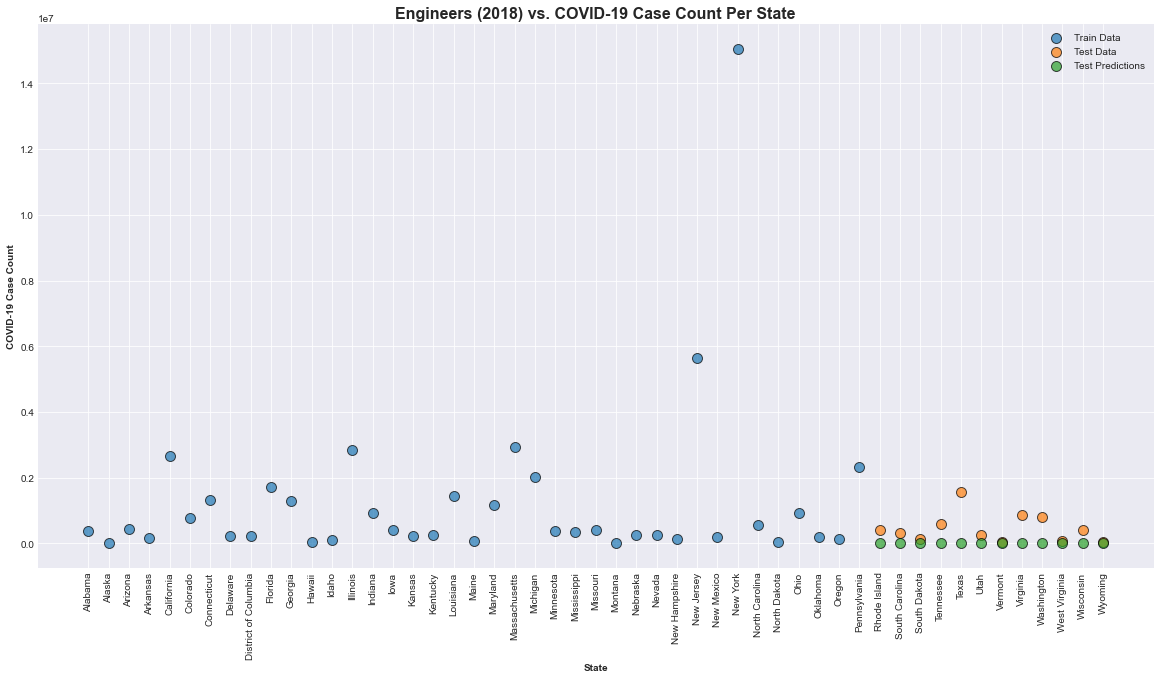

In [54]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Engineers (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [55]:
features_list = ['Life Scientists 2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions = SVRLinModel.predict(X_train_scaled)
test_predictions = SVRLinModel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 451533.25864641607
MSE Value: 387746862043.69507
RMS Value: 622693.2326946352
R2 Score: -1.1088719978974102


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


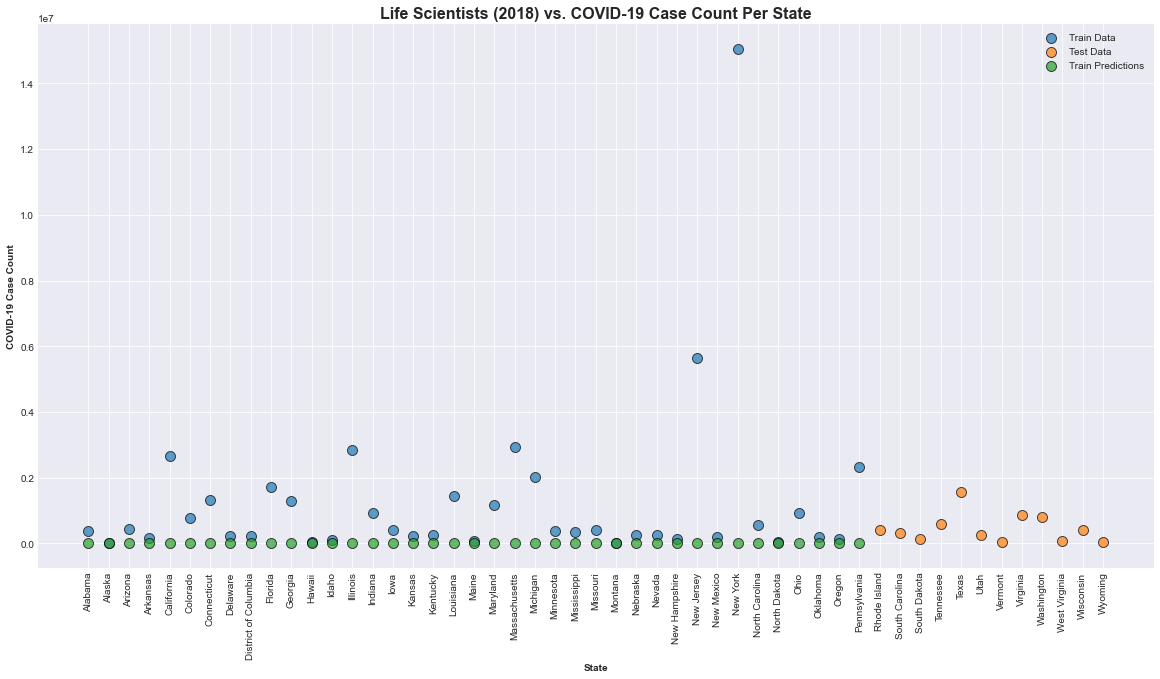

In [56]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Life Scientists (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

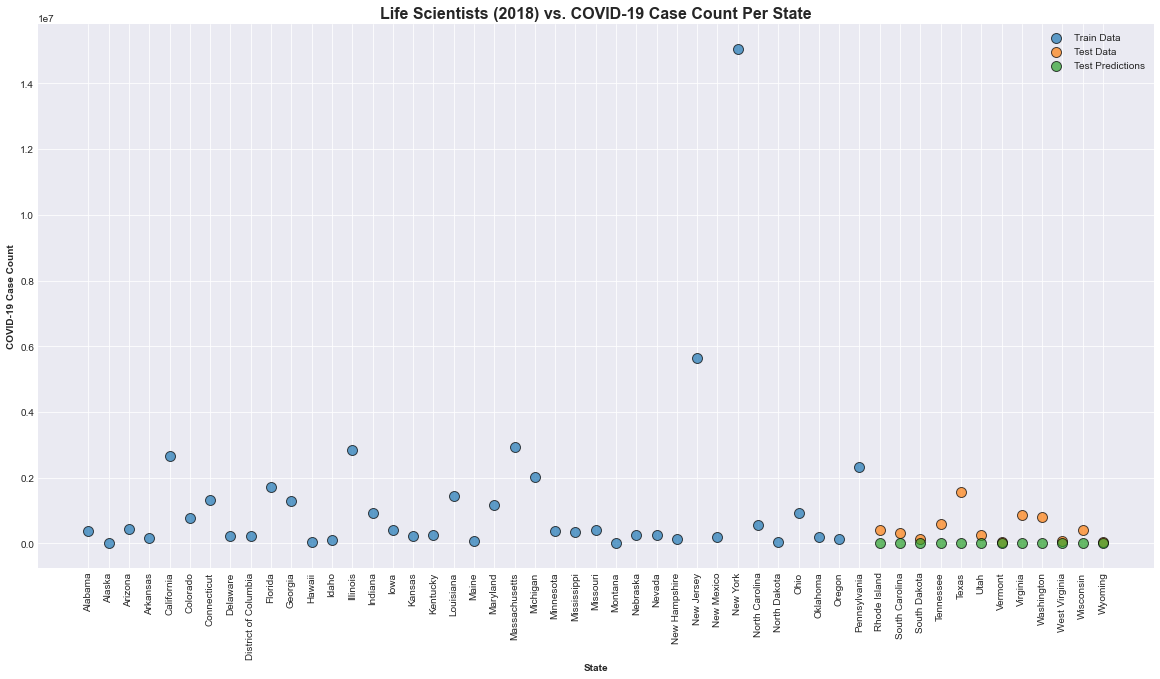

In [57]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Life Scientists (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [58]:
features_list = ['Physical Scientists 2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions = SVRLinModel.predict(X_train_scaled)
test_predictions = SVRLinModel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 451533.247324596
MSE Value: 387746851826.7203
RMS Value: 622693.2244907763
R2 Score: -1.1088719423294764


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


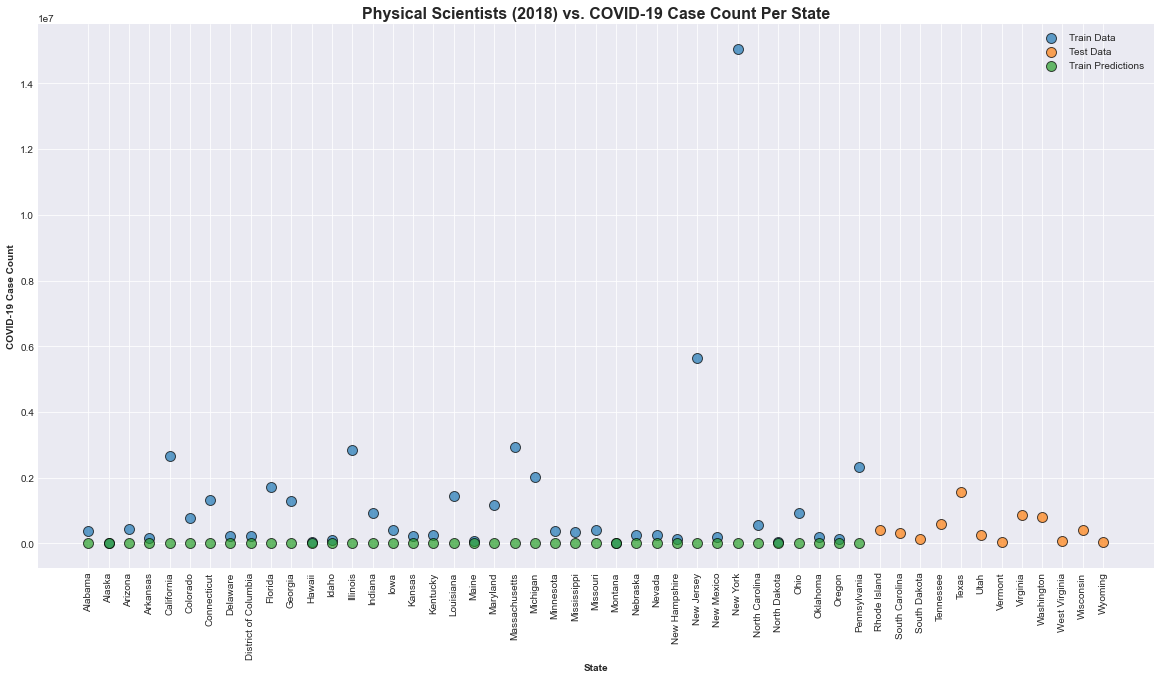

In [59]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Physical Scientists (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

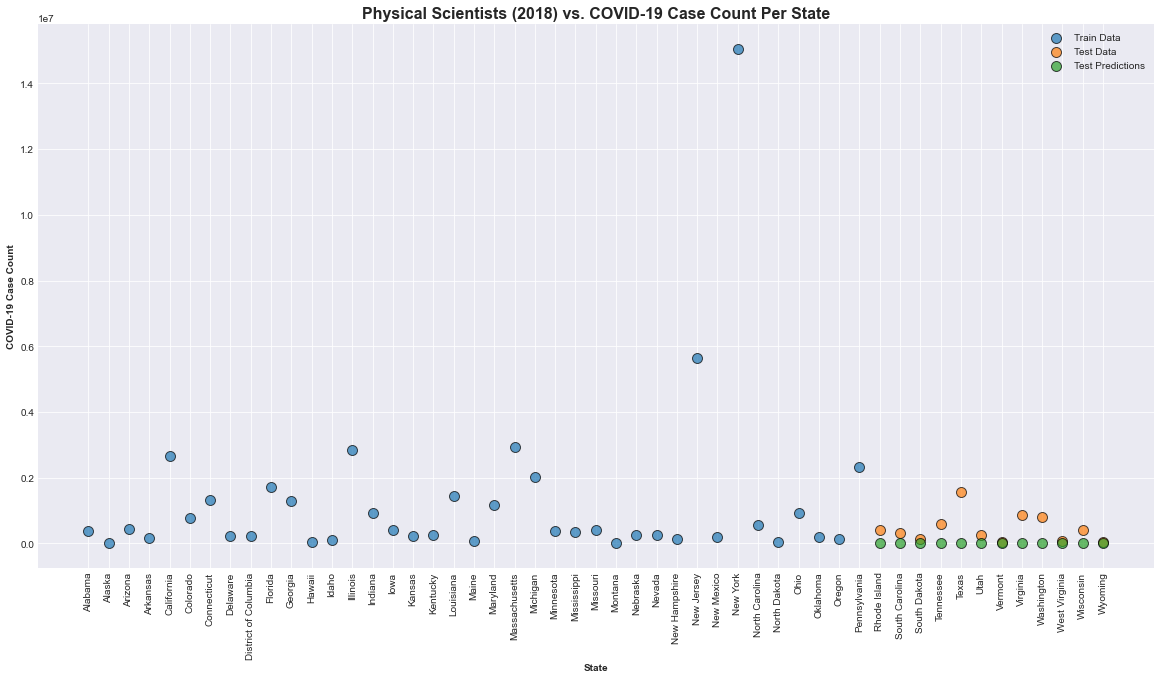

In [60]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Physical Scientists (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [61]:
features_list = ['Science Engineer Workers 2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions = SVRLinModel.predict(X_train_scaled)
test_predictions = SVRLinModel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 451533.2262067458
MSE Value: 387746818156.2551
RMS Value: 622693.1974546174
R2 Score: -1.1088717592030397


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


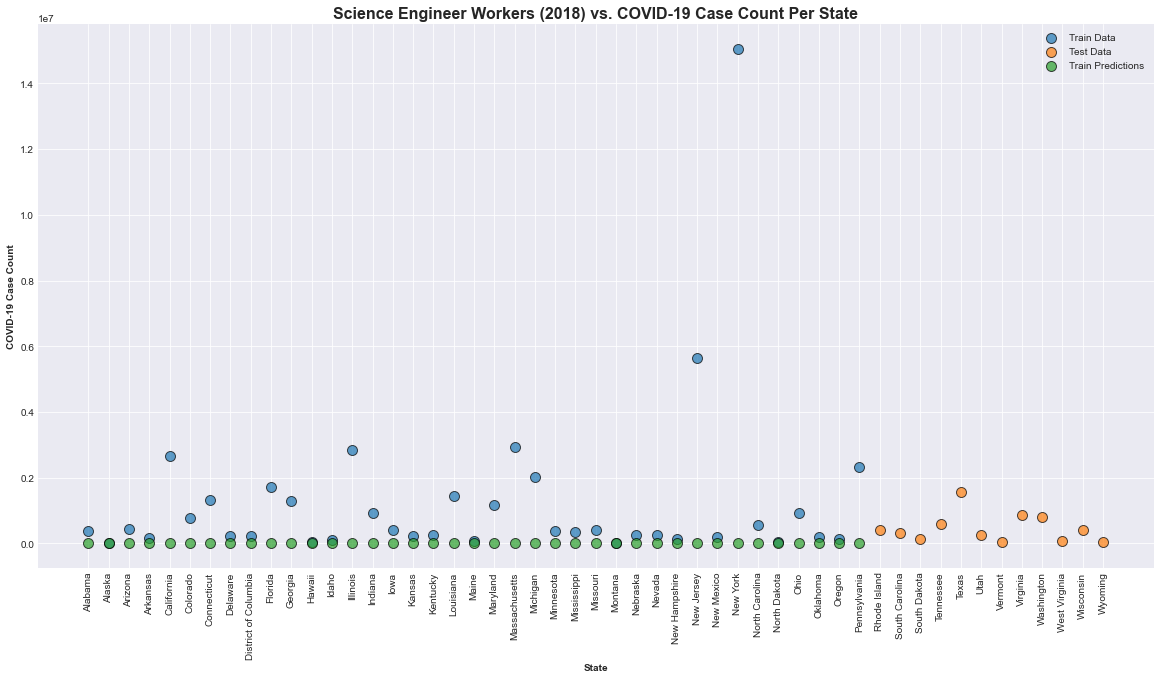

In [62]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Science Engineer Workers (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

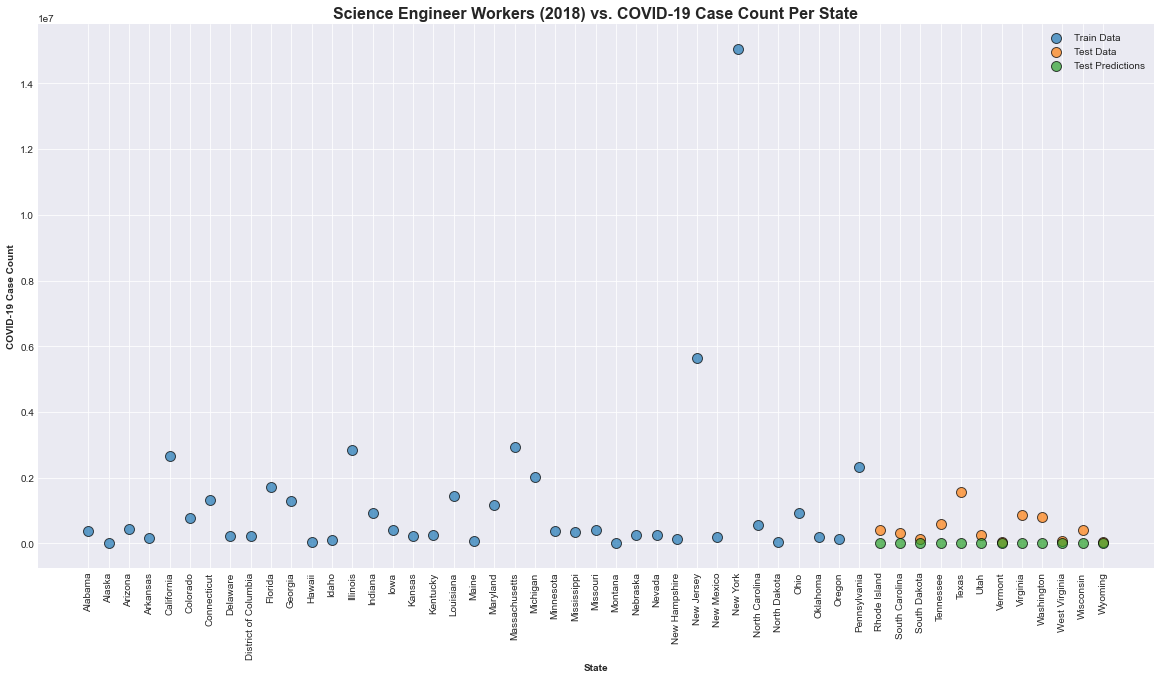

In [63]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Science Engineer Workers (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [64]:
features_list = ['Social Scientists 2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions = SVRLinModel.predict(X_train_scaled)
test_predictions = SVRLinModel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 451533.2341987078
MSE Value: 387746839795.3628
RMS Value: 622693.214830034
R2 Score: -1.1088718768935037


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


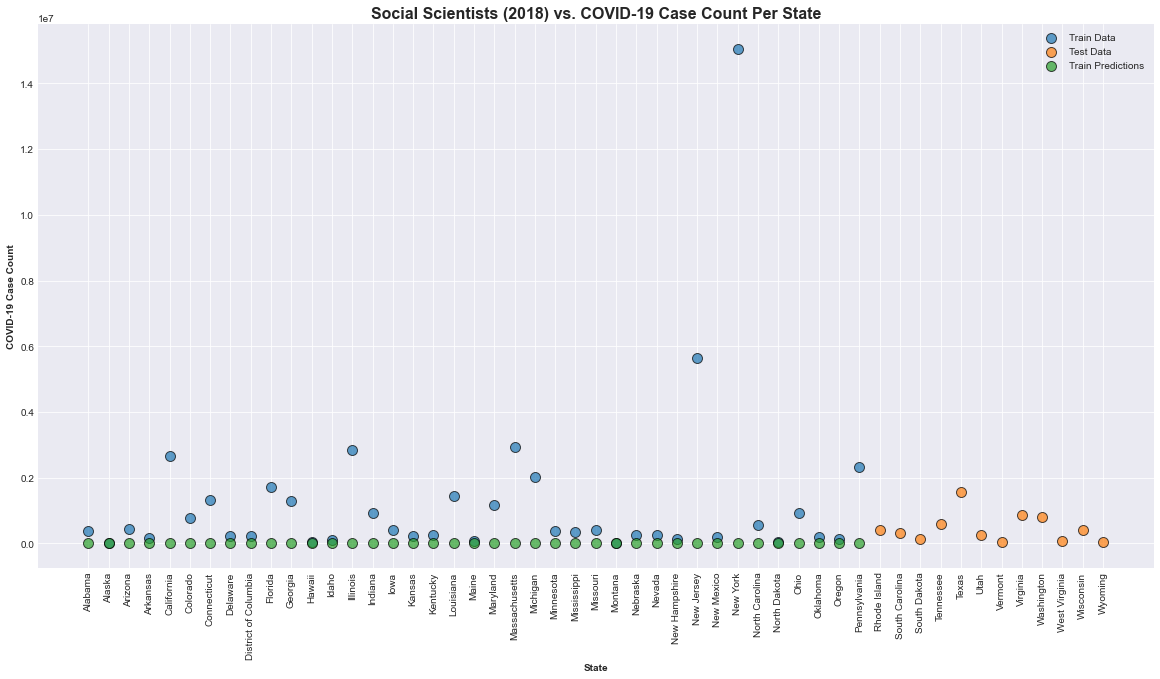

In [65]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Social Scientists (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

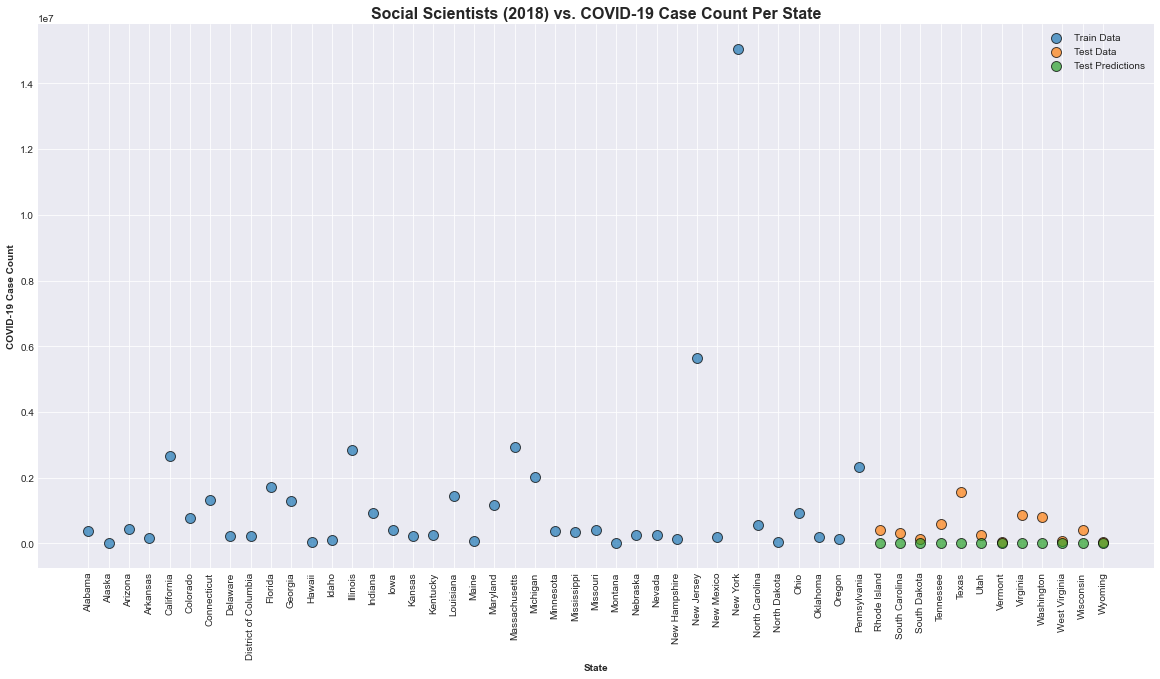

In [66]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Social Scientists (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [67]:
features_list = ['Technical Workers 2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions = SVRLinModel.predict(X_train_scaled)
test_predictions = SVRLinModel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 451533.23636565387
MSE Value: 387746838583.1097
RMS Value: 622693.2138566388
R2 Score: -1.1088718703003195


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


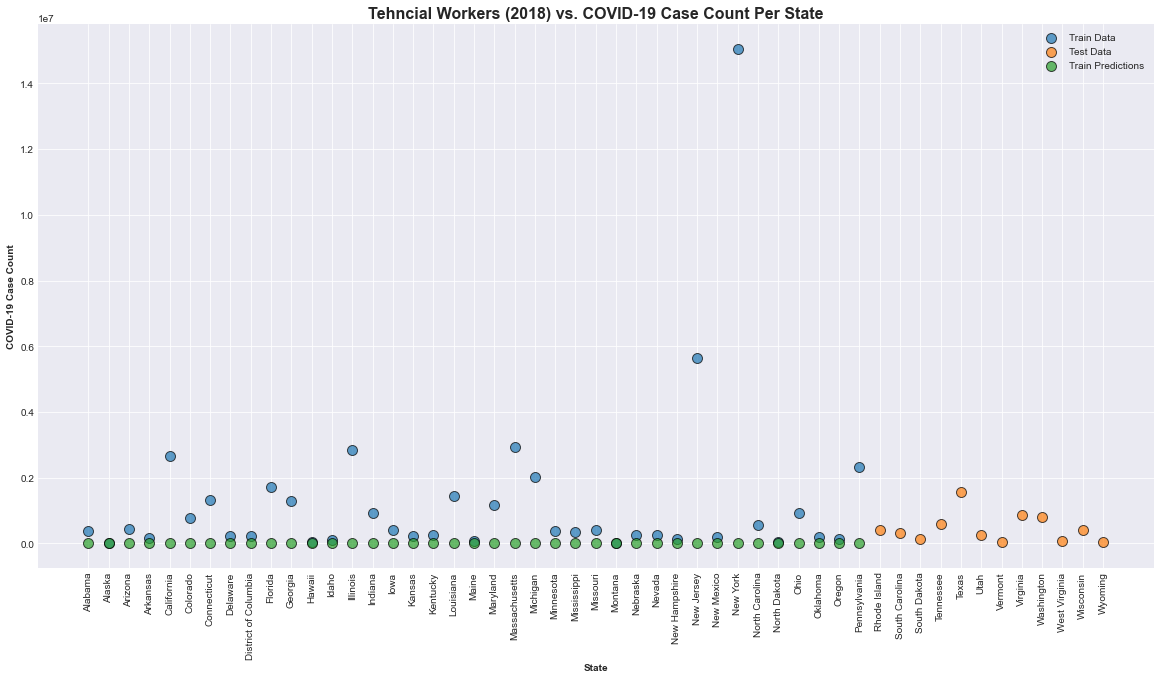

In [68]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Tehncial Workers (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

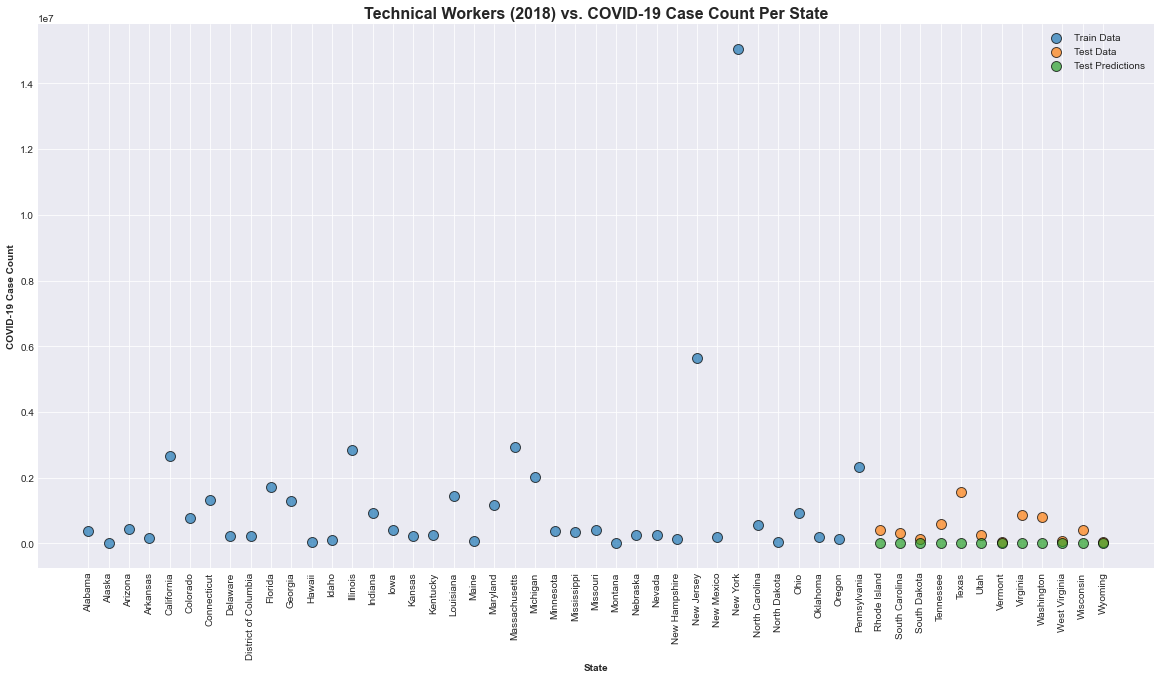

In [69]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Technical Workers (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [70]:
features_list = ['Computer Mathematical Scientists 2018', 'Engineers 2018', 'Life Scientists 2018', 'Physical Scientists 2018',
            'Science Engineer Workers 2018', 'Social Scientists 2018', 'Technical Workers 2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

SVRLinModel = SVR(kernel = 'linear')
SVRLinModel.fit(X_train_scaled, y_train_scaled)

train_predictions = SVRLinModel.predict(X_train_scaled)
test_predictions = SVRLinModel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 451533.2347849566
MSE Value: 387746841468.8787
RMS Value: 622693.2161738063
R2 Score: -1.108871885995398


c:\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


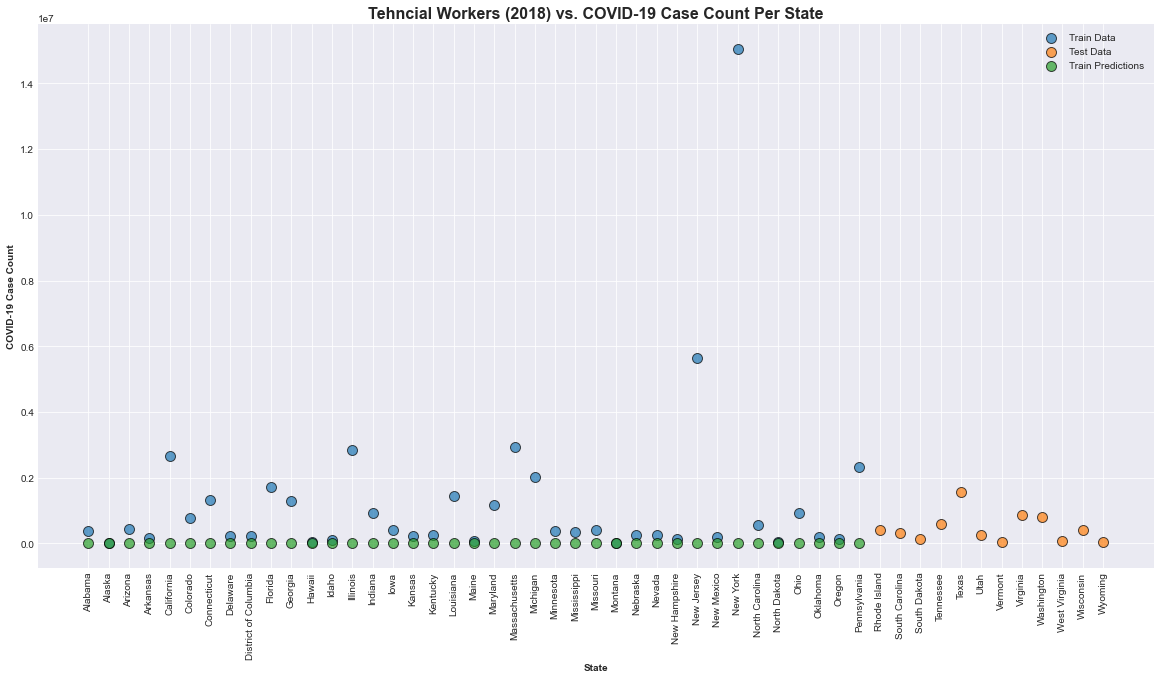

In [71]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Tehncial Workers (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

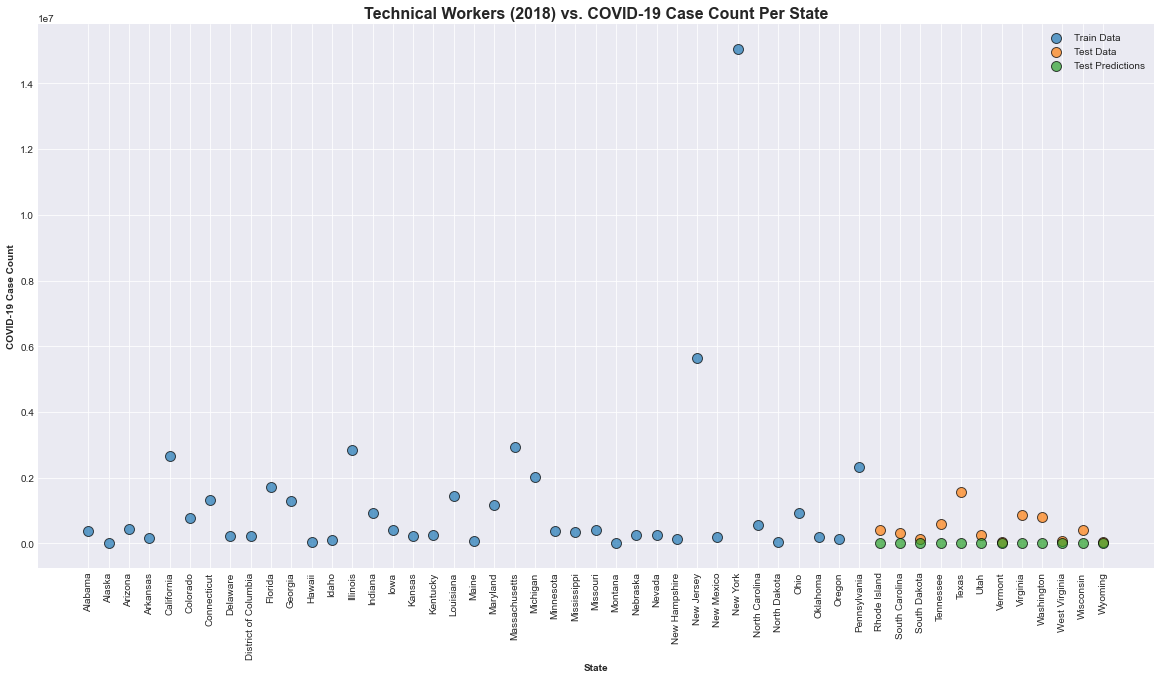

In [72]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Technical Workers (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();